# Fingerprint recognition

## Data
The dataset found at https://neurotechnology.com/download.html is composed by 408 .tif fingerprint images.
Originally the dataset contains 8 different images for each fingerprint and about 6 different fingers for each person. I will treat the different fingers as fingers belonging to distinct persons, so the dataset will contain fingerprints from 51 individuals.

## Fingercode extraction
Before doing the fingerprint recognition I extracted all the fingercodes and saved them as .txt files in order to avoid the extraction process every time.
To do so I used the MATLAB code provided by Luigi Rosa (https://github.com/hbhdytf/fingercode) that uses a bank of Gabor filters to capture both local and global details in a fingerprint as a compact fixed length fingercode. This MATLAB algorithm takes around 0.35 seconds for each image to be processed in order to extract the fingercode. Firstly it finds out the core point of the fingerprint image and around that it builds 5 concentric bands (wide 20 pixels each) all composed by 16 arcs but avoiding the inner circle of radius equal to 12 pixels (the central band is not considered because it is a too small area). Afterwars it uses 8 Gabor filters so the final fingercode will contain 1280 "bits" obtained by concatenating the results of two different rotations of the image (2(n_bands* n_arcs * n_Gabor_filters)).

## Data preparation
All the 408 fingercodes are stored in the "fingercodes" folder, but in order to compute the recognition algorithm and see its performances the dataset is split into training and test sets, with ratio 60:20. Therefore the training set simulates the server database in which are stored 6 fingercodes for each user, while the test set it's used to simulate the authentication request of an user trying to access a service.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
from sklearn.metrics import accuracy_score, precision_score, f1_score

In [2]:
train_images = get_all_image('train')
test_images = get_all_image('test')
print("Size of the training set: ", len(train_images))
print("Size of the training set: ", len(test_images))

Size of the training set:  306
Size of the training set:  102


Next we show how one fingerprint and its related fingercode.

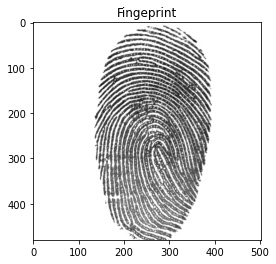

Fingercode: 
 11010000000011111111100000001111111110000001111100110000001111110011100000111110000000000001111000000000001110000000000000111000000000000011110000010000001111000000000001000000000000000110000000000000011000000000000001100000000000000110000000000000110000000000000011000000000000000100000000000000010000000000000011000000000000000100000000000000100000000000000010000000000000001000000000000001100000000000001100000000000000011000000000000001100000000000000100000000000000011000000011111100000000001100000100000001110000110000000011000111000000011100111100000001111111000000001111111100000001111111111000000111111111000000111111111110000111110000000000001111000100000000110100000000000111110001000000011110000110000011111000000000000001000000000000110000000000000011100000000000001100000001100000111000000000000110000000000000011000000000000001100000000000000110000000000000011000000000000001000000000000001100000000000000010000000000000001000000000000011100000000000001000000000000000010

In [3]:
img = mpimg.imread('fingerprints/178_4.tif')
plt.imshow(img)
plt.title('Fingeprint')
plt.show()
print('Fingercode: \n', read_from_file('train/178_4.txt'))

## Results analysis
For each fingercode in the test folder let's see how it performs when compared to all other fingercodes located in the train folder. 
Starting from a test finger it will compute the Euclidean distance from every single train fingercode and also the mean distance from the 6 fingercodes available for every person in the train set. 

In [4]:
total_mean = 0
same_dist = 0
diff_dist = 0
different = 0
same = 0

for test in test_images:
    test_fingercode = read_from_file(test)
    total_dist = 0
    count = 0
    for train in train_images:
        train_fingercode = read_from_file(train)
        dist = euclidean_distance(test_fingercode, train_fingercode)
        total_dist += dist
        count += 1
        if get_image_class(test) == get_image_class(train):
            same_dist += dist
            same += 1
        else:
            diff_dist += dist
            different += 1
        print('Dist from {} to {} is {}'.format(test, train, round(dist)))
        if count == 6:
            count = 0
            mean = total_dist/6
            total_dist = 0
            print('***********************************************************')
            print('Mean dist from {} to all {} is {}'.format(test, get_image_class(train), round(mean)))
            print('***********************************************************')
        
print('---------------------------------------------------------------')
print('Mean for same fingerprints = {}, for different ones = {}'.format(round(same_dist/same), round(diff_dist/different)))

Dist from test/123_1.txt to train/123_3.txt is 182
Dist from test/123_1.txt to train/123_4.txt is 63
Dist from test/123_1.txt to train/123_5.txt is 48
Dist from test/123_1.txt to train/123_6.txt is 163
Dist from test/123_1.txt to train/123_7.txt is 315
Dist from test/123_1.txt to train/123_8.txt is 285
***********************************************************
Mean dist from test/123_1.txt to all 123 is 176
***********************************************************
Dist from test/123_1.txt to train/124_3.txt is 449
Dist from test/123_1.txt to train/124_4.txt is 428
Dist from test/123_1.txt to train/124_5.txt is 268
Dist from test/123_1.txt to train/124_6.txt is 260
Dist from test/123_1.txt to train/124_7.txt is 256
Dist from test/123_1.txt to train/124_8.txt is 262
***********************************************************
Mean dist from test/123_1.txt to all 124 is 320
***********************************************************
Dist from test/123_1.txt to train/125_3.txt is 272
Dis

Dist from test/123_1.txt to train/763_8.txt is 308
***********************************************************
Mean dist from test/123_1.txt to all 763 is 305
***********************************************************
Dist from test/123_1.txt to train/764_2.txt is 314
Dist from test/123_1.txt to train/764_3.txt is 374
Dist from test/123_1.txt to train/764_4.txt is 405
Dist from test/123_1.txt to train/764_6.txt is 307
Dist from test/123_1.txt to train/764_7.txt is 328
Dist from test/123_1.txt to train/764_8.txt is 310
***********************************************************
Mean dist from test/123_1.txt to all 764 is 340
***********************************************************
Dist from test/123_1.txt to train/765_2.txt is 409
Dist from test/123_1.txt to train/765_3.txt is 364
Dist from test/123_1.txt to train/765_4.txt is 513
Dist from test/123_1.txt to train/765_6.txt is 396
Dist from test/123_1.txt to train/765_7.txt is 277
Dist from test/123_1.txt to train/765_8.txt is 309
*

Dist from test/123_2.txt to train/573_7.txt is 238
Dist from test/123_2.txt to train/573_8.txt is 301
***********************************************************
Mean dist from test/123_2.txt to all 573 is 301
***********************************************************
Dist from test/123_2.txt to train/574_3.txt is 324
Dist from test/123_2.txt to train/574_4.txt is 323
Dist from test/123_2.txt to train/574_5.txt is 320
Dist from test/123_2.txt to train/574_6.txt is 413
Dist from test/123_2.txt to train/574_7.txt is 340
Dist from test/123_2.txt to train/574_8.txt is 384
***********************************************************
Mean dist from test/123_2.txt to all 574 is 351
***********************************************************
Dist from test/123_2.txt to train/575_1.txt is 536
Dist from test/123_2.txt to train/575_2.txt is 322
Dist from test/123_2.txt to train/575_3.txt is 523
Dist from test/123_2.txt to train/575_5.txt is 479
Dist from test/123_2.txt to train/575_6.txt is 365
D

Dist from test/124_1.txt to train/573_4.txt is 560
Dist from test/124_1.txt to train/573_5.txt is 576
Dist from test/124_1.txt to train/573_6.txt is 504
Dist from test/124_1.txt to train/573_7.txt is 489
Dist from test/124_1.txt to train/573_8.txt is 584
***********************************************************
Mean dist from test/124_1.txt to all 573 is 546
***********************************************************
Dist from test/124_1.txt to train/574_3.txt is 407
Dist from test/124_1.txt to train/574_4.txt is 464
Dist from test/124_1.txt to train/574_5.txt is 465
Dist from test/124_1.txt to train/574_6.txt is 440
Dist from test/124_1.txt to train/574_7.txt is 361
Dist from test/124_1.txt to train/574_8.txt is 509
***********************************************************
Mean dist from test/124_1.txt to all 574 is 441
***********************************************************
Dist from test/124_1.txt to train/575_1.txt is 697
Dist from test/124_1.txt to train/575_2.txt is 581
D

Dist from test/124_2.txt to train/574_8.txt is 358
***********************************************************
Mean dist from test/124_2.txt to all 574 is 378
***********************************************************
Dist from test/124_2.txt to train/575_1.txt is 588
Dist from test/124_2.txt to train/575_2.txt is 284
Dist from test/124_2.txt to train/575_3.txt is 647
Dist from test/124_2.txt to train/575_5.txt is 597
Dist from test/124_2.txt to train/575_6.txt is 467
Dist from test/124_2.txt to train/575_7.txt is 638
***********************************************************
Mean dist from test/124_2.txt to all 575 is 537
***********************************************************
Dist from test/124_2.txt to train/763_3.txt is 202
Dist from test/124_2.txt to train/763_4.txt is 245
Dist from test/124_2.txt to train/763_5.txt is 217
Dist from test/124_2.txt to train/763_6.txt is 259
Dist from test/124_2.txt to train/763_7.txt is 215
Dist from test/124_2.txt to train/763_8.txt is 208
*

Dist from test/125_1.txt to train/764_6.txt is 209
Dist from test/125_1.txt to train/764_7.txt is 340
Dist from test/125_1.txt to train/764_8.txt is 318
***********************************************************
Mean dist from test/125_1.txt to all 764 is 338
***********************************************************
Dist from test/125_1.txt to train/765_2.txt is 545
Dist from test/125_1.txt to train/765_3.txt is 392
Dist from test/125_1.txt to train/765_4.txt is 495
Dist from test/125_1.txt to train/765_6.txt is 562
Dist from test/125_1.txt to train/765_7.txt is 179
Dist from test/125_1.txt to train/765_8.txt is 183
***********************************************************
Mean dist from test/125_1.txt to all 765 is 393
***********************************************************
Dist from test/125_1.txt to train/766_3.txt is 419
Dist from test/125_1.txt to train/766_4.txt is 413
Dist from test/125_1.txt to train/766_5.txt is 395
Dist from test/125_1.txt to train/766_6.txt is 346
D

Dist from test/125_2.txt to train/765_3.txt is 402
Dist from test/125_2.txt to train/765_4.txt is 537
Dist from test/125_2.txt to train/765_6.txt is 564
Dist from test/125_2.txt to train/765_7.txt is 147
Dist from test/125_2.txt to train/765_8.txt is 165
***********************************************************
Mean dist from test/125_2.txt to all 765 is 395
***********************************************************
Dist from test/125_2.txt to train/766_3.txt is 439
Dist from test/125_2.txt to train/766_4.txt is 437
Dist from test/125_2.txt to train/766_5.txt is 427
Dist from test/125_2.txt to train/766_6.txt is 376
Dist from test/125_2.txt to train/766_7.txt is 401
Dist from test/125_2.txt to train/766_8.txt is 439
***********************************************************
Mean dist from test/125_2.txt to all 766 is 420
***********************************************************
Dist from test/125_2.txt to train/767_2.txt is 328
Dist from test/125_2.txt to train/767_3.txt is 309
D

Dist from test/126_1.txt to train/573_6.txt is 463
Dist from test/126_1.txt to train/573_7.txt is 424
Dist from test/126_1.txt to train/573_8.txt is 417
***********************************************************
Mean dist from test/126_1.txt to all 573 is 433
***********************************************************
Dist from test/126_1.txt to train/574_3.txt is 302
Dist from test/126_1.txt to train/574_4.txt is 321
Dist from test/126_1.txt to train/574_5.txt is 398
Dist from test/126_1.txt to train/574_6.txt is 299
Dist from test/126_1.txt to train/574_7.txt is 310
Dist from test/126_1.txt to train/574_8.txt is 354
***********************************************************
Mean dist from test/126_1.txt to all 574 is 331
***********************************************************
Dist from test/126_1.txt to train/575_1.txt is 690
Dist from test/126_1.txt to train/575_2.txt is 416
Dist from test/126_1.txt to train/575_3.txt is 653
Dist from test/126_1.txt to train/575_5.txt is 595
D

Dist from test/126_2.txt to train/573_3.txt is 394
Dist from test/126_2.txt to train/573_4.txt is 415
Dist from test/126_2.txt to train/573_5.txt is 409
Dist from test/126_2.txt to train/573_6.txt is 443
Dist from test/126_2.txt to train/573_7.txt is 416
Dist from test/126_2.txt to train/573_8.txt is 393
***********************************************************
Mean dist from test/126_2.txt to all 573 is 412
***********************************************************
Dist from test/126_2.txt to train/574_3.txt is 276
Dist from test/126_2.txt to train/574_4.txt is 311
Dist from test/126_2.txt to train/574_5.txt is 410
Dist from test/126_2.txt to train/574_6.txt is 291
Dist from test/126_2.txt to train/574_7.txt is 296
Dist from test/126_2.txt to train/574_8.txt is 348
***********************************************************
Mean dist from test/126_2.txt to all 574 is 322
***********************************************************
Dist from test/126_2.txt to train/575_1.txt is 696
D

Dist from test/127_1.txt to train/474_4.txt is 334
Dist from test/127_1.txt to train/474_5.txt is 336
Dist from test/127_1.txt to train/474_6.txt is 311
Dist from test/127_1.txt to train/474_7.txt is 421
Dist from test/127_1.txt to train/474_8.txt is 353
***********************************************************
Mean dist from test/127_1.txt to all 474 is 362
***********************************************************
Dist from test/127_1.txt to train/475_2.txt is 447
Dist from test/127_1.txt to train/475_3.txt is 450
Dist from test/127_1.txt to train/475_4.txt is 338
Dist from test/127_1.txt to train/475_6.txt is 393
Dist from test/127_1.txt to train/475_7.txt is 343
Dist from test/127_1.txt to train/475_8.txt is 466
***********************************************************
Mean dist from test/127_1.txt to all 475 is 406
***********************************************************
Dist from test/127_1.txt to train/476_2.txt is 415
Dist from test/127_1.txt to train/476_3.txt is 333
D

Dist from test/127_3.txt to train/475_4.txt is 564
Dist from test/127_3.txt to train/475_6.txt is 579
Dist from test/127_3.txt to train/475_7.txt is 559
Dist from test/127_3.txt to train/475_8.txt is 494
***********************************************************
Mean dist from test/127_3.txt to all 475 is 543
***********************************************************
Dist from test/127_3.txt to train/476_2.txt is 603
Dist from test/127_3.txt to train/476_3.txt is 581
Dist from test/127_3.txt to train/476_4.txt is 534
Dist from test/127_3.txt to train/476_5.txt is 680
Dist from test/127_3.txt to train/476_6.txt is 570
Dist from test/127_3.txt to train/476_8.txt is 603
***********************************************************
Mean dist from test/127_3.txt to all 476 is 595
***********************************************************
Dist from test/127_3.txt to train/477_1.txt is 536
Dist from test/127_3.txt to train/477_4.txt is 607
Dist from test/127_3.txt to train/477_5.txt is 571
D

Dist from test/128_2.txt to train/474_3.txt is 418
Dist from test/128_2.txt to train/474_4.txt is 463
Dist from test/128_2.txt to train/474_5.txt is 497
Dist from test/128_2.txt to train/474_6.txt is 522
Dist from test/128_2.txt to train/474_7.txt is 442
Dist from test/128_2.txt to train/474_8.txt is 452
***********************************************************
Mean dist from test/128_2.txt to all 474 is 466
***********************************************************
Dist from test/128_2.txt to train/475_2.txt is 416
Dist from test/128_2.txt to train/475_3.txt is 415
Dist from test/128_2.txt to train/475_4.txt is 501
Dist from test/128_2.txt to train/475_6.txt is 468
Dist from test/128_2.txt to train/475_7.txt is 474
Dist from test/128_2.txt to train/475_8.txt is 359
***********************************************************
Mean dist from test/128_2.txt to all 475 is 439
***********************************************************
Dist from test/128_2.txt to train/476_2.txt is 472
D

Dist from test/128_3.txt to train/457_4.txt is 549
Dist from test/128_3.txt to train/457_5.txt is 546
Dist from test/128_3.txt to train/457_6.txt is 539
Dist from test/128_3.txt to train/457_7.txt is 458
Dist from test/128_3.txt to train/457_8.txt is 539
***********************************************************
Mean dist from test/128_3.txt to all 457 is 528
***********************************************************
Dist from test/128_3.txt to train/458_2.txt is 424
Dist from test/128_3.txt to train/458_4.txt is 438
Dist from test/128_3.txt to train/458_5.txt is 366
Dist from test/128_3.txt to train/458_6.txt is 413
Dist from test/128_3.txt to train/458_7.txt is 429
Dist from test/128_3.txt to train/458_8.txt is 403
***********************************************************
Mean dist from test/128_3.txt to all 458 is 412
***********************************************************
Dist from test/128_3.txt to train/473_2.txt is 513
Dist from test/128_3.txt to train/473_4.txt is 502
D

Dist from test/133_1.txt to train/473_8.txt is 321
***********************************************************
Mean dist from test/133_1.txt to all 473 is 350
***********************************************************
Dist from test/133_1.txt to train/474_3.txt is 462
Dist from test/133_1.txt to train/474_4.txt is 311
Dist from test/133_1.txt to train/474_5.txt is 311
Dist from test/133_1.txt to train/474_6.txt is 258
Dist from test/133_1.txt to train/474_7.txt is 382
Dist from test/133_1.txt to train/474_8.txt is 356
***********************************************************
Mean dist from test/133_1.txt to all 474 is 347
***********************************************************
Dist from test/133_1.txt to train/475_2.txt is 414
Dist from test/133_1.txt to train/475_3.txt is 363
Dist from test/133_1.txt to train/475_4.txt is 313
Dist from test/133_1.txt to train/475_6.txt is 338
Dist from test/133_1.txt to train/475_7.txt is 340
Dist from test/133_1.txt to train/475_8.txt is 493
*

Dist from test/133_2.txt to train/475_3.txt is 457
Dist from test/133_2.txt to train/475_4.txt is 313
Dist from test/133_2.txt to train/475_6.txt is 410
Dist from test/133_2.txt to train/475_7.txt is 340
Dist from test/133_2.txt to train/475_8.txt is 537
***********************************************************
Mean dist from test/133_2.txt to all 475 is 416
***********************************************************
Dist from test/133_2.txt to train/476_2.txt is 478
Dist from test/133_2.txt to train/476_3.txt is 410
Dist from test/133_2.txt to train/476_4.txt is 485
Dist from test/133_2.txt to train/476_5.txt is 645
Dist from test/133_2.txt to train/476_6.txt is 549
Dist from test/133_2.txt to train/476_8.txt is 382
***********************************************************
Mean dist from test/133_2.txt to all 476 is 492
***********************************************************
Dist from test/133_2.txt to train/477_1.txt is 537
Dist from test/133_2.txt to train/477_4.txt is 388
D

Dist from test/134_1.txt to train/573_7.txt is 362
Dist from test/134_1.txt to train/573_8.txt is 277
***********************************************************
Mean dist from test/134_1.txt to all 573 is 316
***********************************************************
Dist from test/134_1.txt to train/574_3.txt is 396
Dist from test/134_1.txt to train/574_4.txt is 329
Dist from test/134_1.txt to train/574_5.txt is 448
Dist from test/134_1.txt to train/574_6.txt is 463
Dist from test/134_1.txt to train/574_7.txt is 408
Dist from test/134_1.txt to train/574_8.txt is 360
***********************************************************
Mean dist from test/134_1.txt to all 574 is 401
***********************************************************
Dist from test/134_1.txt to train/575_1.txt is 536
Dist from test/134_1.txt to train/575_2.txt is 288
Dist from test/134_1.txt to train/575_3.txt is 635
Dist from test/134_1.txt to train/575_5.txt is 597
Dist from test/134_1.txt to train/575_6.txt is 491
D

Dist from test/134_2.txt to train/458_8.txt is 380
***********************************************************
Mean dist from test/134_2.txt to all 458 is 380
***********************************************************
Dist from test/134_2.txt to train/473_2.txt is 336
Dist from test/134_2.txt to train/473_4.txt is 339
Dist from test/134_2.txt to train/473_5.txt is 329
Dist from test/134_2.txt to train/473_6.txt is 329
Dist from test/134_2.txt to train/473_7.txt is 438
Dist from test/134_2.txt to train/473_8.txt is 332
***********************************************************
Mean dist from test/134_2.txt to all 473 is 350
***********************************************************
Dist from test/134_2.txt to train/474_3.txt is 461
Dist from test/134_2.txt to train/474_4.txt is 314
Dist from test/134_2.txt to train/474_5.txt is 316
Dist from test/134_2.txt to train/474_6.txt is 285
Dist from test/134_2.txt to train/474_7.txt is 423
Dist from test/134_2.txt to train/474_8.txt is 367
*

Dist from test/135_1.txt to train/475_3.txt is 452
Dist from test/135_1.txt to train/475_4.txt is 268
Dist from test/135_1.txt to train/475_6.txt is 417
Dist from test/135_1.txt to train/475_7.txt is 257
Dist from test/135_1.txt to train/475_8.txt is 494
***********************************************************
Mean dist from test/135_1.txt to all 475 is 388
***********************************************************
Dist from test/135_1.txt to train/476_2.txt is 419
Dist from test/135_1.txt to train/476_3.txt is 379
Dist from test/135_1.txt to train/476_4.txt is 470
Dist from test/135_1.txt to train/476_5.txt is 564
Dist from test/135_1.txt to train/476_6.txt is 510
Dist from test/135_1.txt to train/476_8.txt is 361
***********************************************************
Mean dist from test/135_1.txt to all 476 is 450
***********************************************************
Dist from test/135_1.txt to train/477_1.txt is 494
Dist from test/135_1.txt to train/477_4.txt is 375
D

Dist from test/135_2.txt to train/458_8.txt is 404
***********************************************************
Mean dist from test/135_2.txt to all 458 is 404
***********************************************************
Dist from test/135_2.txt to train/473_2.txt is 354
Dist from test/135_2.txt to train/473_4.txt is 365
Dist from test/135_2.txt to train/473_5.txt is 359
Dist from test/135_2.txt to train/473_6.txt is 359
Dist from test/135_2.txt to train/473_7.txt is 444
Dist from test/135_2.txt to train/473_8.txt is 378
***********************************************************
Mean dist from test/135_2.txt to all 473 is 376
***********************************************************
Dist from test/135_2.txt to train/474_3.txt is 479
Dist from test/135_2.txt to train/474_4.txt is 334
Dist from test/135_2.txt to train/474_5.txt is 354
Dist from test/135_2.txt to train/474_6.txt is 331
Dist from test/135_2.txt to train/474_7.txt is 461
Dist from test/135_2.txt to train/474_8.txt is 403
*

Dist from test/136_1.txt to train/458_2.txt is 461
Dist from test/136_1.txt to train/458_4.txt is 423
Dist from test/136_1.txt to train/458_5.txt is 499
Dist from test/136_1.txt to train/458_6.txt is 456
Dist from test/136_1.txt to train/458_7.txt is 452
Dist from test/136_1.txt to train/458_8.txt is 466
***********************************************************
Mean dist from test/136_1.txt to all 458 is 460
***********************************************************
Dist from test/136_1.txt to train/473_2.txt is 466
Dist from test/136_1.txt to train/473_4.txt is 473
Dist from test/136_1.txt to train/473_5.txt is 463
Dist from test/136_1.txt to train/473_6.txt is 477
Dist from test/136_1.txt to train/473_7.txt is 456
Dist from test/136_1.txt to train/473_8.txt is 472
***********************************************************
Mean dist from test/136_1.txt to all 473 is 468
***********************************************************
Dist from test/136_1.txt to train/474_3.txt is 521
D

Dist from test/136_2.txt to train/457_7.txt is 468
Dist from test/136_2.txt to train/457_8.txt is 473
***********************************************************
Mean dist from test/136_2.txt to all 457 is 462
***********************************************************
Dist from test/136_2.txt to train/458_2.txt is 468
Dist from test/136_2.txt to train/458_4.txt is 424
Dist from test/136_2.txt to train/458_5.txt is 506
Dist from test/136_2.txt to train/458_6.txt is 469
Dist from test/136_2.txt to train/458_7.txt is 459
Dist from test/136_2.txt to train/458_8.txt is 469
***********************************************************
Mean dist from test/136_2.txt to all 458 is 466
***********************************************************
Dist from test/136_2.txt to train/473_2.txt is 487
Dist from test/136_2.txt to train/473_4.txt is 490
Dist from test/136_2.txt to train/473_5.txt is 478
Dist from test/136_2.txt to train/473_6.txt is 490
Dist from test/136_2.txt to train/473_7.txt is 459
D

Dist from test/137_1.txt to train/456_4.txt is 368
Dist from test/137_1.txt to train/456_5.txt is 383
Dist from test/137_1.txt to train/456_6.txt is 387
Dist from test/137_1.txt to train/456_7.txt is 397
Dist from test/137_1.txt to train/456_8.txt is 378
***********************************************************
Mean dist from test/137_1.txt to all 456 is 385
***********************************************************
Dist from test/137_1.txt to train/457_1.txt is 344
Dist from test/137_1.txt to train/457_4.txt is 352
Dist from test/137_1.txt to train/457_5.txt is 331
Dist from test/137_1.txt to train/457_6.txt is 344
Dist from test/137_1.txt to train/457_7.txt is 509
Dist from test/137_1.txt to train/457_8.txt is 364
***********************************************************
Mean dist from test/137_1.txt to all 457 is 374
***********************************************************
Dist from test/137_1.txt to train/458_2.txt is 409
Dist from test/137_1.txt to train/458_4.txt is 355
D

Dist from test/137_2.txt to train/454_7.txt is 192
Dist from test/137_2.txt to train/454_8.txt is 191
***********************************************************
Mean dist from test/137_2.txt to all 454 is 194
***********************************************************
Dist from test/137_2.txt to train/455_3.txt is 218
Dist from test/137_2.txt to train/455_4.txt is 194
Dist from test/137_2.txt to train/455_5.txt is 193
Dist from test/137_2.txt to train/455_6.txt is 197
Dist from test/137_2.txt to train/455_7.txt is 342
Dist from test/137_2.txt to train/455_8.txt is 401
***********************************************************
Mean dist from test/137_2.txt to all 455 is 258
***********************************************************
Dist from test/137_2.txt to train/456_3.txt is 407
Dist from test/137_2.txt to train/456_4.txt is 380
Dist from test/137_2.txt to train/456_5.txt is 389
Dist from test/137_2.txt to train/456_6.txt is 401
Dist from test/137_2.txt to train/456_7.txt is 411
D

Dist from test/138_3.txt to train/453_7.txt is 613
Dist from test/138_3.txt to train/453_8.txt is 594
***********************************************************
Mean dist from test/138_3.txt to all 453 is 614
***********************************************************
Dist from test/138_3.txt to train/454_3.txt is 705
Dist from test/138_3.txt to train/454_4.txt is 706
Dist from test/138_3.txt to train/454_5.txt is 700
Dist from test/138_3.txt to train/454_6.txt is 691
Dist from test/138_3.txt to train/454_7.txt is 702
Dist from test/138_3.txt to train/454_8.txt is 701
***********************************************************
Mean dist from test/138_3.txt to all 454 is 701
***********************************************************
Dist from test/138_3.txt to train/455_3.txt is 746
Dist from test/138_3.txt to train/455_4.txt is 718
Dist from test/138_3.txt to train/455_5.txt is 723
Dist from test/138_3.txt to train/455_6.txt is 735
Dist from test/138_3.txt to train/455_7.txt is 688
D

Dist from test/138_5.txt to train/275_7.txt is 625
Dist from test/138_5.txt to train/275_8.txt is 642
***********************************************************
Mean dist from test/138_5.txt to all 275 is 601
***********************************************************
Dist from test/138_5.txt to train/276_2.txt is 521
Dist from test/138_5.txt to train/276_4.txt is 598
Dist from test/138_5.txt to train/276_5.txt is 672
Dist from test/138_5.txt to train/276_6.txt is 565
Dist from test/138_5.txt to train/276_7.txt is 634
Dist from test/138_5.txt to train/276_8.txt is 613
***********************************************************
Mean dist from test/138_5.txt to all 276 is 600
***********************************************************
Dist from test/138_5.txt to train/277_3.txt is 658
Dist from test/138_5.txt to train/277_4.txt is 585
Dist from test/138_5.txt to train/277_5.txt is 605
Dist from test/138_5.txt to train/277_6.txt is 633
Dist from test/138_5.txt to train/277_7.txt is 615
D

Dist from test/173_2.txt to train/276_5.txt is 357
Dist from test/173_2.txt to train/276_6.txt is 386
Dist from test/173_2.txt to train/276_7.txt is 349
Dist from test/173_2.txt to train/276_8.txt is 310
***********************************************************
Mean dist from test/173_2.txt to all 276 is 362
***********************************************************
Dist from test/173_2.txt to train/277_3.txt is 331
Dist from test/173_2.txt to train/277_4.txt is 290
Dist from test/173_2.txt to train/277_5.txt is 294
Dist from test/173_2.txt to train/277_6.txt is 308
Dist from test/173_2.txt to train/277_7.txt is 306
Dist from test/173_2.txt to train/277_8.txt is 283
***********************************************************
Mean dist from test/173_2.txt to all 277 is 302
***********************************************************
Dist from test/173_2.txt to train/278_2.txt is 347
Dist from test/173_2.txt to train/278_3.txt is 344
Dist from test/173_2.txt to train/278_4.txt is 369
D

Dist from test/173_3.txt to train/454_7.txt is 220
Dist from test/173_3.txt to train/454_8.txt is 217
***********************************************************
Mean dist from test/173_3.txt to all 454 is 223
***********************************************************
Dist from test/173_3.txt to train/455_3.txt is 252
Dist from test/173_3.txt to train/455_4.txt is 228
Dist from test/173_3.txt to train/455_5.txt is 221
Dist from test/173_3.txt to train/455_6.txt is 233
Dist from test/173_3.txt to train/455_7.txt is 340
Dist from test/173_3.txt to train/455_8.txt is 345
***********************************************************
Mean dist from test/173_3.txt to all 455 is 270
***********************************************************
Dist from test/173_3.txt to train/456_3.txt is 351
Dist from test/173_3.txt to train/456_4.txt is 350
Dist from test/173_3.txt to train/456_5.txt is 351
Dist from test/173_3.txt to train/456_6.txt is 351
Dist from test/173_3.txt to train/456_7.txt is 369
D

Dist from test/174_1.txt to train/278_2.txt is 333
Dist from test/174_1.txt to train/278_3.txt is 508
Dist from test/174_1.txt to train/278_4.txt is 457
Dist from test/174_1.txt to train/278_5.txt is 512
Dist from test/174_1.txt to train/278_7.txt is 416
Dist from test/174_1.txt to train/278_8.txt is 383
***********************************************************
Mean dist from test/174_1.txt to all 278 is 435
***********************************************************
Dist from test/174_1.txt to train/453_3.txt is 285
Dist from test/174_1.txt to train/453_4.txt is 286
Dist from test/174_1.txt to train/453_5.txt is 277
Dist from test/174_1.txt to train/453_6.txt is 246
Dist from test/174_1.txt to train/453_7.txt is 260
Dist from test/174_1.txt to train/453_8.txt is 265
***********************************************************
Mean dist from test/174_1.txt to all 453 is 270
***********************************************************
Dist from test/174_1.txt to train/454_3.txt is 220
D

Dist from test/174_2.txt to train/277_7.txt is 310
Dist from test/174_2.txt to train/277_8.txt is 279
***********************************************************
Mean dist from test/174_2.txt to all 277 is 312
***********************************************************
Dist from test/174_2.txt to train/278_2.txt is 293
Dist from test/174_2.txt to train/278_3.txt is 526
Dist from test/174_2.txt to train/278_4.txt is 427
Dist from test/174_2.txt to train/278_5.txt is 512
Dist from test/174_2.txt to train/278_7.txt is 392
Dist from test/174_2.txt to train/278_8.txt is 353
***********************************************************
Mean dist from test/174_2.txt to all 278 is 417
***********************************************************
Dist from test/174_2.txt to train/453_3.txt is 287
Dist from test/174_2.txt to train/453_4.txt is 294
Dist from test/174_2.txt to train/453_5.txt is 289
Dist from test/174_2.txt to train/453_6.txt is 254
Dist from test/174_2.txt to train/453_7.txt is 270
D

Dist from test/175_2.txt to train/275_5.txt is 420
Dist from test/175_2.txt to train/275_6.txt is 441
Dist from test/175_2.txt to train/275_7.txt is 417
Dist from test/175_2.txt to train/275_8.txt is 404
***********************************************************
Mean dist from test/175_2.txt to all 275 is 406
***********************************************************
Dist from test/175_2.txt to train/276_2.txt is 385
Dist from test/175_2.txt to train/276_4.txt is 396
Dist from test/175_2.txt to train/276_5.txt is 372
Dist from test/175_2.txt to train/276_6.txt is 387
Dist from test/175_2.txt to train/276_7.txt is 368
Dist from test/175_2.txt to train/276_8.txt is 321
***********************************************************
Mean dist from test/175_2.txt to all 276 is 372
***********************************************************
Dist from test/175_2.txt to train/277_3.txt is 312
Dist from test/175_2.txt to train/277_4.txt is 291
Dist from test/175_2.txt to train/277_5.txt is 273
D

Dist from test/175_3.txt to train/274_5.txt is 399
Dist from test/175_3.txt to train/274_6.txt is 361
Dist from test/175_3.txt to train/274_7.txt is 314
Dist from test/175_3.txt to train/274_8.txt is 383
***********************************************************
Mean dist from test/175_3.txt to all 274 is 361
***********************************************************
Dist from test/175_3.txt to train/275_3.txt is 500
Dist from test/175_3.txt to train/275_4.txt is 443
Dist from test/175_3.txt to train/275_5.txt is 498
Dist from test/175_3.txt to train/275_6.txt is 513
Dist from test/175_3.txt to train/275_7.txt is 499
Dist from test/175_3.txt to train/275_8.txt is 470
***********************************************************
Mean dist from test/175_3.txt to all 275 is 487
***********************************************************
Dist from test/175_3.txt to train/276_2.txt is 465
Dist from test/175_3.txt to train/276_4.txt is 430
Dist from test/175_3.txt to train/276_5.txt is 396
D

Dist from test/176_1.txt to train/228_2.txt is 337
Dist from test/176_1.txt to train/228_3.txt is 345
Dist from test/176_1.txt to train/228_4.txt is 323
Dist from test/176_1.txt to train/228_5.txt is 334
Dist from test/176_1.txt to train/228_6.txt is 355
***********************************************************
Mean dist from test/176_1.txt to all 228 is 336
***********************************************************
Dist from test/176_1.txt to train/273_1.txt is 379
Dist from test/176_1.txt to train/273_2.txt is 417
Dist from test/176_1.txt to train/273_4.txt is 375
Dist from test/176_1.txt to train/273_5.txt is 386
Dist from test/176_1.txt to train/273_7.txt is 452
Dist from test/176_1.txt to train/273_8.txt is 354
***********************************************************
Mean dist from test/176_1.txt to all 273 is 394
***********************************************************
Dist from test/176_1.txt to train/274_2.txt is 353
Dist from test/176_1.txt to train/274_3.txt is 402
D

Dist from test/176_2.txt to train/275_5.txt is 438
Dist from test/176_2.txt to train/275_6.txt is 489
Dist from test/176_2.txt to train/275_7.txt is 531
Dist from test/176_2.txt to train/275_8.txt is 382
***********************************************************
Mean dist from test/176_2.txt to all 275 is 465
***********************************************************
Dist from test/176_2.txt to train/276_2.txt is 325
Dist from test/176_2.txt to train/276_4.txt is 494
Dist from test/176_2.txt to train/276_5.txt is 518
Dist from test/176_2.txt to train/276_6.txt is 459
Dist from test/176_2.txt to train/276_7.txt is 430
Dist from test/176_2.txt to train/276_8.txt is 221
***********************************************************
Mean dist from test/176_2.txt to all 276 is 408
***********************************************************
Dist from test/176_2.txt to train/277_3.txt is 250
Dist from test/176_2.txt to train/277_4.txt is 247
Dist from test/176_2.txt to train/277_5.txt is 257
D

Dist from test/177_1.txt to train/276_4.txt is 509
Dist from test/177_1.txt to train/276_5.txt is 563
Dist from test/177_1.txt to train/276_6.txt is 470
Dist from test/177_1.txt to train/276_7.txt is 499
Dist from test/177_1.txt to train/276_8.txt is 260
***********************************************************
Mean dist from test/177_1.txt to all 276 is 442
***********************************************************
Dist from test/177_1.txt to train/277_3.txt is 275
Dist from test/177_1.txt to train/277_4.txt is 238
Dist from test/177_1.txt to train/277_5.txt is 236
Dist from test/177_1.txt to train/277_6.txt is 254
Dist from test/177_1.txt to train/277_7.txt is 238
Dist from test/177_1.txt to train/277_8.txt is 237
***********************************************************
Mean dist from test/177_1.txt to all 277 is 246
***********************************************************
Dist from test/177_1.txt to train/278_2.txt is 215
Dist from test/177_1.txt to train/278_3.txt is 524
D

Dist from test/177_2.txt to train/226_1.txt is 607
Dist from test/177_2.txt to train/226_2.txt is 273
Dist from test/177_2.txt to train/226_3.txt is 455
Dist from test/177_2.txt to train/226_4.txt is 576
Dist from test/177_2.txt to train/226_5.txt is 471
Dist from test/177_2.txt to train/226_6.txt is 410
***********************************************************
Mean dist from test/177_2.txt to all 226 is 465
***********************************************************
Dist from test/177_2.txt to train/227_1.txt is 471
Dist from test/177_2.txt to train/227_2.txt is 446
Dist from test/177_2.txt to train/227_3.txt is 391
Dist from test/177_2.txt to train/227_4.txt is 391
Dist from test/177_2.txt to train/227_5.txt is 407
Dist from test/177_2.txt to train/227_6.txt is 417
***********************************************************
Mean dist from test/177_2.txt to all 227 is 420
***********************************************************
Dist from test/177_2.txt to train/228_1.txt is 362
D

Dist from test/178_1.txt to train/226_4.txt is 531
Dist from test/178_1.txt to train/226_5.txt is 448
Dist from test/178_1.txt to train/226_6.txt is 385
***********************************************************
Mean dist from test/178_1.txt to all 226 is 442
***********************************************************
Dist from test/178_1.txt to train/227_1.txt is 450
Dist from test/178_1.txt to train/227_2.txt is 433
Dist from test/178_1.txt to train/227_3.txt is 380
Dist from test/178_1.txt to train/227_4.txt is 384
Dist from test/178_1.txt to train/227_5.txt is 406
Dist from test/178_1.txt to train/227_6.txt is 420
***********************************************************
Mean dist from test/178_1.txt to all 227 is 412
***********************************************************
Dist from test/178_1.txt to train/228_1.txt is 347
Dist from test/178_1.txt to train/228_2.txt is 266
Dist from test/178_1.txt to train/228_3.txt is 326
Dist from test/178_1.txt to train/228_4.txt is 334
D

Dist from test/178_2.txt to train/178_5.txt is 86
Dist from test/178_2.txt to train/178_6.txt is 188
Dist from test/178_2.txt to train/178_7.txt is 75
Dist from test/178_2.txt to train/178_8.txt is 117
***********************************************************
Mean dist from test/178_2.txt to all 178 is 108
***********************************************************
Dist from test/178_2.txt to train/223_1.txt is 379
Dist from test/178_2.txt to train/223_2.txt is 352
Dist from test/178_2.txt to train/223_3.txt is 376
Dist from test/178_2.txt to train/223_5.txt is 340
Dist from test/178_2.txt to train/223_6.txt is 304
Dist from test/178_2.txt to train/223_7.txt is 387
***********************************************************
Mean dist from test/178_2.txt to all 223 is 356
***********************************************************
Dist from test/178_2.txt to train/224_3.txt is 299
Dist from test/178_2.txt to train/224_4.txt is 268
Dist from test/178_2.txt to train/224_5.txt is 360
Dis

Dist from test/223_4.txt to train/176_8.txt is 349
***********************************************************
Mean dist from test/223_4.txt to all 176 is 332
***********************************************************
Dist from test/223_4.txt to train/177_3.txt is 335
Dist from test/223_4.txt to train/177_4.txt is 461
Dist from test/223_4.txt to train/177_5.txt is 360
Dist from test/223_4.txt to train/177_6.txt is 341
Dist from test/223_4.txt to train/177_7.txt is 340
Dist from test/223_4.txt to train/177_8.txt is 320
***********************************************************
Mean dist from test/223_4.txt to all 177 is 360
***********************************************************
Dist from test/223_4.txt to train/178_3.txt is 302
Dist from test/223_4.txt to train/178_4.txt is 297
Dist from test/223_4.txt to train/178_5.txt is 316
Dist from test/223_4.txt to train/178_6.txt is 288
Dist from test/223_4.txt to train/178_7.txt is 319
Dist from test/223_4.txt to train/178_8.txt is 289
*

Dist from test/223_8.txt to train/138_6.txt is 577
Dist from test/223_8.txt to train/138_7.txt is 563
Dist from test/223_8.txt to train/138_8.txt is 591
***********************************************************
Mean dist from test/223_8.txt to all 138 is 558
***********************************************************
Dist from test/223_8.txt to train/173_1.txt is 423
Dist from test/223_8.txt to train/173_4.txt is 418
Dist from test/223_8.txt to train/173_5.txt is 414
Dist from test/223_8.txt to train/173_6.txt is 408
Dist from test/223_8.txt to train/173_7.txt is 445
Dist from test/223_8.txt to train/173_8.txt is 401
***********************************************************
Mean dist from test/223_8.txt to all 173 is 418
***********************************************************
Dist from test/223_8.txt to train/174_3.txt is 487
Dist from test/223_8.txt to train/174_4.txt is 499
Dist from test/223_8.txt to train/174_5.txt is 480
Dist from test/223_8.txt to train/174_6.txt is 490
D

Dist from test/224_1.txt to train/136_7.txt is 450
Dist from test/224_1.txt to train/136_8.txt is 461
***********************************************************
Mean dist from test/224_1.txt to all 136 is 457
***********************************************************
Dist from test/224_1.txt to train/137_3.txt is 252
Dist from test/224_1.txt to train/137_4.txt is 250
Dist from test/224_1.txt to train/137_5.txt is 287
Dist from test/224_1.txt to train/137_6.txt is 260
Dist from test/224_1.txt to train/137_7.txt is 216
Dist from test/224_1.txt to train/137_8.txt is 239
***********************************************************
Mean dist from test/224_1.txt to all 137 is 251
***********************************************************
Dist from test/224_1.txt to train/138_1.txt is 558
Dist from test/224_1.txt to train/138_2.txt is 478
Dist from test/224_1.txt to train/138_4.txt is 592
Dist from test/224_1.txt to train/138_6.txt is 664
Dist from test/224_1.txt to train/138_7.txt is 554
D

Dist from test/224_2.txt to train/128_6.txt is 574
Dist from test/224_2.txt to train/128_7.txt is 544
Dist from test/224_2.txt to train/128_8.txt is 456
***********************************************************
Mean dist from test/224_2.txt to all 128 is 494
***********************************************************
Dist from test/224_2.txt to train/133_3.txt is 291
Dist from test/224_2.txt to train/133_4.txt is 511
Dist from test/224_2.txt to train/133_5.txt is 301
Dist from test/224_2.txt to train/133_6.txt is 381
Dist from test/224_2.txt to train/133_7.txt is 408
Dist from test/224_2.txt to train/133_8.txt is 303
***********************************************************
Mean dist from test/224_2.txt to all 133 is 366
***********************************************************
Dist from test/224_2.txt to train/134_3.txt is 272
Dist from test/224_2.txt to train/134_4.txt is 264
Dist from test/224_2.txt to train/134_5.txt is 266
Dist from test/224_2.txt to train/134_6.txt is 378
D

Dist from test/225_7.txt to train/124_3.txt is 542
Dist from test/225_7.txt to train/124_4.txt is 547
Dist from test/225_7.txt to train/124_5.txt is 603
Dist from test/225_7.txt to train/124_6.txt is 583
Dist from test/225_7.txt to train/124_7.txt is 597
Dist from test/225_7.txt to train/124_8.txt is 589
***********************************************************
Mean dist from test/225_7.txt to all 124 is 577
***********************************************************
Dist from test/225_7.txt to train/125_3.txt is 549
Dist from test/225_7.txt to train/125_4.txt is 508
Dist from test/225_7.txt to train/125_5.txt is 526
Dist from test/225_7.txt to train/125_6.txt is 536
Dist from test/225_7.txt to train/125_7.txt is 523
Dist from test/225_7.txt to train/125_8.txt is 489
***********************************************************
Mean dist from test/225_7.txt to all 125 is 522
***********************************************************
Dist from test/225_7.txt to train/126_3.txt is 565
D

Dist from test/225_7.txt to train/767_2.txt is 519
Dist from test/225_7.txt to train/767_3.txt is 560
Dist from test/225_7.txt to train/767_5.txt is 396
Dist from test/225_7.txt to train/767_6.txt is 593
Dist from test/225_7.txt to train/767_7.txt is 589
Dist from test/225_7.txt to train/767_8.txt is 503
***********************************************************
Mean dist from test/225_7.txt to all 767 is 527
***********************************************************
Dist from test/225_7.txt to train/768_1.txt is 450
Dist from test/225_7.txt to train/768_2.txt is 323
Dist from test/225_7.txt to train/768_4.txt is 594
Dist from test/225_7.txt to train/768_5.txt is 586
Dist from test/225_7.txt to train/768_6.txt is 383
Dist from test/225_7.txt to train/768_7.txt is 442
***********************************************************
Mean dist from test/225_7.txt to all 768 is 463
***********************************************************
Dist from test/225_8.txt to train/123_3.txt is 456
D

Dist from test/225_8.txt to train/573_8.txt is 535
***********************************************************
Mean dist from test/225_8.txt to all 573 is 506
***********************************************************
Dist from test/225_8.txt to train/574_3.txt is 558
Dist from test/225_8.txt to train/574_4.txt is 559
Dist from test/225_8.txt to train/574_5.txt is 460
Dist from test/225_8.txt to train/574_6.txt is 579
Dist from test/225_8.txt to train/574_7.txt is 580
Dist from test/225_8.txt to train/574_8.txt is 574
***********************************************************
Mean dist from test/225_8.txt to all 574 is 552
***********************************************************
Dist from test/225_8.txt to train/575_1.txt is 292
Dist from test/225_8.txt to train/575_2.txt is 480
Dist from test/225_8.txt to train/575_3.txt is 235
Dist from test/225_8.txt to train/575_5.txt is 407
Dist from test/225_8.txt to train/575_6.txt is 313
Dist from test/225_8.txt to train/575_7.txt is 214
*

Dist from test/226_7.txt to train/478_3.txt is 328
Dist from test/226_7.txt to train/478_4.txt is 474
Dist from test/226_7.txt to train/478_5.txt is 434
Dist from test/226_7.txt to train/478_6.txt is 477
Dist from test/226_7.txt to train/478_7.txt is 477
Dist from test/226_7.txt to train/478_8.txt is 507
***********************************************************
Mean dist from test/226_7.txt to all 478 is 450
***********************************************************
Dist from test/226_7.txt to train/573_3.txt is 602
Dist from test/226_7.txt to train/573_4.txt is 511
Dist from test/226_7.txt to train/573_5.txt is 553
Dist from test/226_7.txt to train/573_6.txt is 485
Dist from test/226_7.txt to train/573_7.txt is 510
Dist from test/226_7.txt to train/573_8.txt is 583
***********************************************************
Mean dist from test/226_7.txt to all 573 is 541
***********************************************************
Dist from test/226_7.txt to train/574_3.txt is 572
D

Dist from test/226_8.txt to train/458_7.txt is 217
Dist from test/226_8.txt to train/458_8.txt is 251
***********************************************************
Mean dist from test/226_8.txt to all 458 is 242
***********************************************************
Dist from test/226_8.txt to train/473_2.txt is 283
Dist from test/226_8.txt to train/473_4.txt is 330
Dist from test/226_8.txt to train/473_5.txt is 302
Dist from test/226_8.txt to train/473_6.txt is 336
Dist from test/226_8.txt to train/473_7.txt is 325
Dist from test/226_8.txt to train/473_8.txt is 327
***********************************************************
Mean dist from test/226_8.txt to all 473 is 317
***********************************************************
Dist from test/226_8.txt to train/474_3.txt is 344
Dist from test/226_8.txt to train/474_4.txt is 353
Dist from test/226_8.txt to train/474_5.txt is 317
Dist from test/226_8.txt to train/474_6.txt is 330
Dist from test/226_8.txt to train/474_7.txt is 336
D

Dist from test/227_7.txt to train/458_2.txt is 400
Dist from test/227_7.txt to train/458_4.txt is 338
Dist from test/227_7.txt to train/458_5.txt is 418
Dist from test/227_7.txt to train/458_6.txt is 349
Dist from test/227_7.txt to train/458_7.txt is 347
Dist from test/227_7.txt to train/458_8.txt is 335
***********************************************************
Mean dist from test/227_7.txt to all 458 is 364
***********************************************************
Dist from test/227_7.txt to train/473_2.txt is 413
Dist from test/227_7.txt to train/473_4.txt is 382
Dist from test/227_7.txt to train/473_5.txt is 368
Dist from test/227_7.txt to train/473_6.txt is 356
Dist from test/227_7.txt to train/473_7.txt is 419
Dist from test/227_7.txt to train/473_8.txt is 343
***********************************************************
Mean dist from test/227_7.txt to all 473 is 380
***********************************************************
Dist from test/227_7.txt to train/474_3.txt is 440
D

Dist from test/227_8.txt to train/457_5.txt is 396
Dist from test/227_8.txt to train/457_6.txt is 391
Dist from test/227_8.txt to train/457_7.txt is 468
Dist from test/227_8.txt to train/457_8.txt is 393
***********************************************************
Mean dist from test/227_8.txt to all 457 is 404
***********************************************************
Dist from test/227_8.txt to train/458_2.txt is 424
Dist from test/227_8.txt to train/458_4.txt is 380
Dist from test/227_8.txt to train/458_5.txt is 374
Dist from test/227_8.txt to train/458_6.txt is 373
Dist from test/227_8.txt to train/458_7.txt is 365
Dist from test/227_8.txt to train/458_8.txt is 379
***********************************************************
Mean dist from test/227_8.txt to all 458 is 382
***********************************************************
Dist from test/227_8.txt to train/473_2.txt is 323
Dist from test/227_8.txt to train/473_4.txt is 364
Dist from test/227_8.txt to train/473_5.txt is 332
D

Dist from test/228_7.txt to train/456_3.txt is 406
Dist from test/228_7.txt to train/456_4.txt is 395
Dist from test/228_7.txt to train/456_5.txt is 402
Dist from test/228_7.txt to train/456_6.txt is 402
Dist from test/228_7.txt to train/456_7.txt is 382
Dist from test/228_7.txt to train/456_8.txt is 387
***********************************************************
Mean dist from test/228_7.txt to all 456 is 396
***********************************************************
Dist from test/228_7.txt to train/457_1.txt is 401
Dist from test/228_7.txt to train/457_4.txt is 401
Dist from test/228_7.txt to train/457_5.txt is 412
Dist from test/228_7.txt to train/457_6.txt is 399
Dist from test/228_7.txt to train/457_7.txt is 348
Dist from test/228_7.txt to train/457_8.txt is 399
***********************************************************
Mean dist from test/228_7.txt to all 457 is 393
***********************************************************
Dist from test/228_7.txt to train/458_2.txt is 326
D

Dist from test/228_8.txt to train/456_4.txt is 385
Dist from test/228_8.txt to train/456_5.txt is 394
Dist from test/228_8.txt to train/456_6.txt is 394
Dist from test/228_8.txt to train/456_7.txt is 376
Dist from test/228_8.txt to train/456_8.txt is 381
***********************************************************
Mean dist from test/228_8.txt to all 456 is 389
***********************************************************
Dist from test/228_8.txt to train/457_1.txt is 387
Dist from test/228_8.txt to train/457_4.txt is 387
Dist from test/228_8.txt to train/457_5.txt is 396
Dist from test/228_8.txt to train/457_6.txt is 391
Dist from test/228_8.txt to train/457_7.txt is 320
Dist from test/228_8.txt to train/457_8.txt is 389
***********************************************************
Mean dist from test/228_8.txt to all 457 is 378
***********************************************************
Dist from test/228_8.txt to train/458_2.txt is 304
Dist from test/228_8.txt to train/458_4.txt is 324
D

Dist from test/273_3.txt to train/474_5.txt is 233
Dist from test/273_3.txt to train/474_6.txt is 220
Dist from test/273_3.txt to train/474_7.txt is 348
Dist from test/273_3.txt to train/474_8.txt is 318
***********************************************************
Mean dist from test/273_3.txt to all 474 is 294
***********************************************************
Dist from test/273_3.txt to train/475_2.txt is 374
Dist from test/273_3.txt to train/475_3.txt is 367
Dist from test/273_3.txt to train/475_4.txt is 281
Dist from test/273_3.txt to train/475_6.txt is 322
Dist from test/273_3.txt to train/475_7.txt is 266
Dist from test/273_3.txt to train/475_8.txt is 477
***********************************************************
Mean dist from test/273_3.txt to all 475 is 348
***********************************************************
Dist from test/273_3.txt to train/476_2.txt is 386
Dist from test/273_3.txt to train/476_3.txt is 306
Dist from test/273_3.txt to train/476_4.txt is 425
D

Dist from test/273_6.txt to train/456_3.txt is 375
Dist from test/273_6.txt to train/456_4.txt is 410
Dist from test/273_6.txt to train/456_5.txt is 405
Dist from test/273_6.txt to train/456_6.txt is 405
Dist from test/273_6.txt to train/456_7.txt is 429
Dist from test/273_6.txt to train/456_8.txt is 444
***********************************************************
Mean dist from test/273_6.txt to all 456 is 411
***********************************************************
Dist from test/273_6.txt to train/457_1.txt is 386
Dist from test/273_6.txt to train/457_4.txt is 398
Dist from test/273_6.txt to train/457_5.txt is 387
Dist from test/273_6.txt to train/457_6.txt is 378
Dist from test/273_6.txt to train/457_7.txt is 405
Dist from test/273_6.txt to train/457_8.txt is 406
***********************************************************
Mean dist from test/273_6.txt to all 457 is 393
***********************************************************
Dist from test/273_6.txt to train/458_2.txt is 459
D

Dist from test/274_1.txt to train/458_6.txt is 385
Dist from test/274_1.txt to train/458_7.txt is 371
Dist from test/274_1.txt to train/458_8.txt is 359
***********************************************************
Mean dist from test/274_1.txt to all 458 is 384
***********************************************************
Dist from test/274_1.txt to train/473_2.txt is 461
Dist from test/274_1.txt to train/473_4.txt is 464
Dist from test/274_1.txt to train/473_5.txt is 454
Dist from test/274_1.txt to train/473_6.txt is 442
Dist from test/274_1.txt to train/473_7.txt is 413
Dist from test/274_1.txt to train/473_8.txt is 469
***********************************************************
Mean dist from test/274_1.txt to all 473 is 450
***********************************************************
Dist from test/274_1.txt to train/474_3.txt is 466
Dist from test/274_1.txt to train/474_4.txt is 385
Dist from test/274_1.txt to train/474_5.txt is 431
Dist from test/274_1.txt to train/474_6.txt is 408
D

***********************************************************
Dist from test/274_4.txt to train/474_3.txt is 433
Dist from test/274_4.txt to train/474_4.txt is 372
Dist from test/274_4.txt to train/474_5.txt is 384
Dist from test/274_4.txt to train/474_6.txt is 385
Dist from test/274_4.txt to train/474_7.txt is 399
Dist from test/274_4.txt to train/474_8.txt is 381
***********************************************************
Mean dist from test/274_4.txt to all 474 is 392
***********************************************************
Dist from test/274_4.txt to train/475_2.txt is 315
Dist from test/274_4.txt to train/475_3.txt is 350
Dist from test/274_4.txt to train/475_4.txt is 302
Dist from test/274_4.txt to train/475_6.txt is 389
Dist from test/274_4.txt to train/475_7.txt is 335
Dist from test/274_4.txt to train/475_8.txt is 416
***********************************************************
Mean dist from test/274_4.txt to all 475 is 351
****************************************************

Dist from test/275_1.txt to train/477_4.txt is 479
Dist from test/275_1.txt to train/477_5.txt is 437
Dist from test/275_1.txt to train/477_6.txt is 490
Dist from test/275_1.txt to train/477_7.txt is 488
Dist from test/275_1.txt to train/477_8.txt is 501
***********************************************************
Mean dist from test/275_1.txt to all 477 is 443
***********************************************************
Dist from test/275_1.txt to train/478_3.txt is 372
Dist from test/275_1.txt to train/478_4.txt is 468
Dist from test/275_1.txt to train/478_5.txt is 352
Dist from test/275_1.txt to train/478_6.txt is 453
Dist from test/275_1.txt to train/478_7.txt is 457
Dist from test/275_1.txt to train/478_8.txt is 481
***********************************************************
Mean dist from test/275_1.txt to all 478 is 430
***********************************************************
Dist from test/275_1.txt to train/573_3.txt is 512
Dist from test/275_1.txt to train/573_4.txt is 453
D

Dist from test/275_2.txt to train/573_4.txt is 406
Dist from test/275_2.txt to train/573_5.txt is 398
Dist from test/275_2.txt to train/573_6.txt is 406
Dist from test/275_2.txt to train/573_7.txt is 443
Dist from test/275_2.txt to train/573_8.txt is 442
***********************************************************
Mean dist from test/275_2.txt to all 573 is 423
***********************************************************
Dist from test/275_2.txt to train/574_3.txt is 459
Dist from test/275_2.txt to train/574_4.txt is 456
Dist from test/275_2.txt to train/574_5.txt is 387
Dist from test/275_2.txt to train/574_6.txt is 478
Dist from test/275_2.txt to train/574_7.txt is 555
Dist from test/275_2.txt to train/574_8.txt is 443
***********************************************************
Mean dist from test/275_2.txt to all 574 is 463
***********************************************************
Dist from test/275_2.txt to train/575_1.txt is 481
Dist from test/275_2.txt to train/575_2.txt is 459
D

Dist from test/276_1.txt to train/575_3.txt is 581
Dist from test/276_1.txt to train/575_5.txt is 557
Dist from test/276_1.txt to train/575_6.txt is 447
Dist from test/276_1.txt to train/575_7.txt is 618
***********************************************************
Mean dist from test/276_1.txt to all 575 is 508
***********************************************************
Dist from test/276_1.txt to train/763_3.txt is 394
Dist from test/276_1.txt to train/763_4.txt is 321
Dist from test/276_1.txt to train/763_5.txt is 397
Dist from test/276_1.txt to train/763_6.txt is 381
Dist from test/276_1.txt to train/763_7.txt is 395
Dist from test/276_1.txt to train/763_8.txt is 390
***********************************************************
Mean dist from test/276_1.txt to all 763 is 380
***********************************************************
Dist from test/276_1.txt to train/764_2.txt is 278
Dist from test/276_1.txt to train/764_3.txt is 534
Dist from test/276_1.txt to train/764_4.txt is 539
D

Dist from test/276_3.txt to train/764_7.txt is 437
Dist from test/276_3.txt to train/764_8.txt is 365
***********************************************************
Mean dist from test/276_3.txt to all 764 is 413
***********************************************************
Dist from test/276_3.txt to train/765_2.txt is 512
Dist from test/276_3.txt to train/765_3.txt is 433
Dist from test/276_3.txt to train/765_4.txt is 392
Dist from test/276_3.txt to train/765_6.txt is 515
Dist from test/276_3.txt to train/765_7.txt is 358
Dist from test/276_3.txt to train/765_8.txt is 374
***********************************************************
Mean dist from test/276_3.txt to all 765 is 431
***********************************************************
Dist from test/276_3.txt to train/766_3.txt is 220
Dist from test/276_3.txt to train/766_4.txt is 228
Dist from test/276_3.txt to train/766_5.txt is 212
Dist from test/276_3.txt to train/766_6.txt is 167
Dist from test/276_3.txt to train/766_7.txt is 202
D

Mean dist from test/277_1.txt to all 766 is 253
***********************************************************
Dist from test/277_1.txt to train/767_2.txt is 245
Dist from test/277_1.txt to train/767_3.txt is 200
Dist from test/277_1.txt to train/767_5.txt is 450
Dist from test/277_1.txt to train/767_6.txt is 205
Dist from test/277_1.txt to train/767_7.txt is 189
Dist from test/277_1.txt to train/767_8.txt is 289
***********************************************************
Mean dist from test/277_1.txt to all 767 is 263
***********************************************************
Dist from test/277_1.txt to train/768_1.txt is 330
Dist from test/277_1.txt to train/768_2.txt is 521
Dist from test/277_1.txt to train/768_4.txt is 228
Dist from test/277_1.txt to train/768_5.txt is 226
Dist from test/277_1.txt to train/768_6.txt is 407
Dist from test/277_1.txt to train/768_7.txt is 336
***********************************************************
Mean dist from test/277_1.txt to all 768 is 341
****

Dist from test/277_2.txt to train/768_7.txt is 337
***********************************************************
Mean dist from test/277_2.txt to all 768 is 329
***********************************************************
Dist from test/278_1.txt to train/123_3.txt is 281
Dist from test/278_1.txt to train/123_4.txt is 318
Dist from test/278_1.txt to train/123_5.txt is 273
Dist from test/278_1.txt to train/123_6.txt is 338
Dist from test/278_1.txt to train/123_7.txt is 360
Dist from test/278_1.txt to train/123_8.txt is 272
***********************************************************
Mean dist from test/278_1.txt to all 123 is 307
***********************************************************
Dist from test/278_1.txt to train/124_3.txt is 594
Dist from test/278_1.txt to train/124_4.txt is 579
Dist from test/278_1.txt to train/124_5.txt is 197
Dist from test/278_1.txt to train/124_6.txt is 201
Dist from test/278_1.txt to train/124_7.txt is 191
Dist from test/278_1.txt to train/124_8.txt is 199
*

Dist from test/278_6.txt to train/125_4.txt is 295
Dist from test/278_6.txt to train/125_5.txt is 287
Dist from test/278_6.txt to train/125_6.txt is 289
Dist from test/278_6.txt to train/125_7.txt is 266
Dist from test/278_6.txt to train/125_8.txt is 440
***********************************************************
Mean dist from test/278_6.txt to all 125 is 303
***********************************************************
Dist from test/278_6.txt to train/126_3.txt is 394
Dist from test/278_6.txt to train/126_4.txt is 464
Dist from test/278_6.txt to train/126_5.txt is 391
Dist from test/278_6.txt to train/126_6.txt is 388
Dist from test/278_6.txt to train/126_7.txt is 392
Dist from test/278_6.txt to train/126_8.txt is 385
***********************************************************
Mean dist from test/278_6.txt to all 126 is 402
***********************************************************
Dist from test/278_6.txt to train/127_2.txt is 179
Dist from test/278_6.txt to train/127_4.txt is 606
D

Dist from test/453_1.txt to train/126_4.txt is 380
Dist from test/453_1.txt to train/126_5.txt is 345
Dist from test/453_1.txt to train/126_6.txt is 368
Dist from test/453_1.txt to train/126_7.txt is 354
Dist from test/453_1.txt to train/126_8.txt is 351
***********************************************************
Mean dist from test/453_1.txt to all 126 is 362
***********************************************************
Dist from test/453_1.txt to train/127_2.txt is 211
Dist from test/453_1.txt to train/127_4.txt is 510
Dist from test/453_1.txt to train/127_5.txt is 190
Dist from test/453_1.txt to train/127_6.txt is 515
Dist from test/453_1.txt to train/127_7.txt is 517
Dist from test/453_1.txt to train/127_8.txt is 477
***********************************************************
Mean dist from test/453_1.txt to all 127 is 403
***********************************************************
Dist from test/453_1.txt to train/128_1.txt is 336
Dist from test/453_1.txt to train/128_4.txt is 345
D

Dist from test/453_2.txt to train/126_5.txt is 350
Dist from test/453_2.txt to train/126_6.txt is 375
Dist from test/453_2.txt to train/126_7.txt is 363
Dist from test/453_2.txt to train/126_8.txt is 356
***********************************************************
Mean dist from test/453_2.txt to all 126 is 369
***********************************************************
Dist from test/453_2.txt to train/127_2.txt is 206
Dist from test/453_2.txt to train/127_4.txt is 527
Dist from test/453_2.txt to train/127_5.txt is 183
Dist from test/453_2.txt to train/127_6.txt is 532
Dist from test/453_2.txt to train/127_7.txt is 534
Dist from test/453_2.txt to train/127_8.txt is 486
***********************************************************
Mean dist from test/453_2.txt to all 127 is 411
***********************************************************
Dist from test/453_2.txt to train/128_1.txt is 357
Dist from test/453_2.txt to train/128_4.txt is 346
Dist from test/453_2.txt to train/128_5.txt is 412
D

Dist from test/454_1.txt to train/127_8.txt is 556
***********************************************************
Mean dist from test/454_1.txt to all 127 is 460
***********************************************************
Dist from test/454_1.txt to train/128_1.txt is 465
Dist from test/454_1.txt to train/128_4.txt is 462
Dist from test/454_1.txt to train/128_5.txt is 540
Dist from test/454_1.txt to train/128_6.txt is 601
Dist from test/454_1.txt to train/128_7.txt is 571
Dist from test/454_1.txt to train/128_8.txt is 479
***********************************************************
Mean dist from test/454_1.txt to all 128 is 520
***********************************************************
Dist from test/454_1.txt to train/133_3.txt is 184
Dist from test/454_1.txt to train/133_4.txt is 488
Dist from test/454_1.txt to train/133_5.txt is 166
Dist from test/454_1.txt to train/133_6.txt is 350
Dist from test/454_1.txt to train/133_7.txt is 393
Dist from test/454_1.txt to train/133_8.txt is 262
*

Dist from test/454_2.txt to train/134_6.txt is 387
Dist from test/454_2.txt to train/134_7.txt is 199
Dist from test/454_2.txt to train/134_8.txt is 111
***********************************************************
Mean dist from test/454_2.txt to all 134 is 181
***********************************************************
Dist from test/454_2.txt to train/135_3.txt is 158
Dist from test/454_2.txt to train/135_4.txt is 167
Dist from test/454_2.txt to train/135_5.txt is 152
Dist from test/454_2.txt to train/135_6.txt is 160
Dist from test/454_2.txt to train/135_7.txt is 154
Dist from test/454_2.txt to train/135_8.txt is 149
***********************************************************
Mean dist from test/454_2.txt to all 135 is 157
***********************************************************
Dist from test/454_2.txt to train/136_3.txt is 572
Dist from test/454_2.txt to train/136_4.txt is 458
Dist from test/454_2.txt to train/136_5.txt is 374
Dist from test/454_2.txt to train/136_6.txt is 457
D

Dist from test/455_1.txt to train/175_1.txt is 545
Dist from test/455_1.txt to train/175_4.txt is 257
Dist from test/455_1.txt to train/175_5.txt is 259
Dist from test/455_1.txt to train/175_6.txt is 291
Dist from test/455_1.txt to train/175_7.txt is 210
Dist from test/455_1.txt to train/175_8.txt is 549
***********************************************************
Mean dist from test/455_1.txt to all 175 is 352
***********************************************************
Dist from test/455_1.txt to train/176_3.txt is 347
Dist from test/455_1.txt to train/176_4.txt is 333
Dist from test/455_1.txt to train/176_5.txt is 336
Dist from test/455_1.txt to train/176_6.txt is 339
Dist from test/455_1.txt to train/176_7.txt is 266
Dist from test/455_1.txt to train/176_8.txt is 321
***********************************************************
Mean dist from test/455_1.txt to all 176 is 324
***********************************************************
Dist from test/455_1.txt to train/177_3.txt is 321
D

Dist from test/455_2.txt to train/176_4.txt is 314
Dist from test/455_2.txt to train/176_5.txt is 317
Dist from test/455_2.txt to train/176_6.txt is 320
Dist from test/455_2.txt to train/176_7.txt is 239
Dist from test/455_2.txt to train/176_8.txt is 300
***********************************************************
Mean dist from test/455_2.txt to all 176 is 304
***********************************************************
Dist from test/455_2.txt to train/177_3.txt is 320
Dist from test/455_2.txt to train/177_4.txt is 464
Dist from test/455_2.txt to train/177_5.txt is 317
Dist from test/455_2.txt to train/177_6.txt is 334
Dist from test/455_2.txt to train/177_7.txt is 317
Dist from test/455_2.txt to train/177_8.txt is 307
***********************************************************
Mean dist from test/455_2.txt to all 177 is 343
***********************************************************
Dist from test/455_2.txt to train/178_3.txt is 323
Dist from test/455_2.txt to train/178_4.txt is 300
D

Dist from test/456_1.txt to train/178_6.txt is 263
Dist from test/456_1.txt to train/178_7.txt is 286
Dist from test/456_1.txt to train/178_8.txt is 232
***********************************************************
Mean dist from test/456_1.txt to all 178 is 271
***********************************************************
Dist from test/456_1.txt to train/223_1.txt is 302
Dist from test/456_1.txt to train/223_2.txt is 335
Dist from test/456_1.txt to train/223_3.txt is 405
Dist from test/456_1.txt to train/223_5.txt is 323
Dist from test/456_1.txt to train/223_6.txt is 297
Dist from test/456_1.txt to train/223_7.txt is 442
***********************************************************
Mean dist from test/456_1.txt to all 223 is 351
***********************************************************
Dist from test/456_1.txt to train/224_3.txt is 246
Dist from test/456_1.txt to train/224_4.txt is 231
Dist from test/456_1.txt to train/224_5.txt is 233
Dist from test/456_1.txt to train/224_6.txt is 240
D

Dist from test/456_2.txt to train/224_3.txt is 243
Dist from test/456_2.txt to train/224_4.txt is 226
Dist from test/456_2.txt to train/224_5.txt is 236
Dist from test/456_2.txt to train/224_6.txt is 225
Dist from test/456_2.txt to train/224_7.txt is 235
Dist from test/456_2.txt to train/224_8.txt is 245
***********************************************************
Mean dist from test/456_2.txt to all 224 is 235
***********************************************************
Dist from test/456_2.txt to train/225_1.txt is 533
Dist from test/456_2.txt to train/225_2.txt is 551
Dist from test/456_2.txt to train/225_3.txt is 371
Dist from test/456_2.txt to train/225_4.txt is 360
Dist from test/456_2.txt to train/225_5.txt is 595
Dist from test/456_2.txt to train/225_6.txt is 250
***********************************************************
Mean dist from test/456_2.txt to all 225 is 443
***********************************************************
Dist from test/456_2.txt to train/226_1.txt is 509
D

Dist from test/457_2.txt to train/273_7.txt is 371
Dist from test/457_2.txt to train/273_8.txt is 365
***********************************************************
Mean dist from test/457_2.txt to all 273 is 324
***********************************************************
Dist from test/457_2.txt to train/274_2.txt is 240
Dist from test/457_2.txt to train/274_3.txt is 347
Dist from test/457_2.txt to train/274_5.txt is 248
Dist from test/457_2.txt to train/274_6.txt is 474
Dist from test/457_2.txt to train/274_7.txt is 439
Dist from test/457_2.txt to train/274_8.txt is 370
***********************************************************
Mean dist from test/457_2.txt to all 274 is 353
***********************************************************
Dist from test/457_2.txt to train/275_3.txt is 507
Dist from test/457_2.txt to train/275_4.txt is 516
Dist from test/457_2.txt to train/275_5.txt is 443
Dist from test/457_2.txt to train/275_6.txt is 520
Dist from test/457_2.txt to train/275_7.txt is 604
D

Dist from test/457_3.txt to train/276_4.txt is 474
Dist from test/457_3.txt to train/276_5.txt is 564
Dist from test/457_3.txt to train/276_6.txt is 443
Dist from test/457_3.txt to train/276_7.txt is 420
Dist from test/457_3.txt to train/276_8.txt is 155
***********************************************************
Mean dist from test/457_3.txt to all 276 is 383
***********************************************************
Dist from test/457_3.txt to train/277_3.txt is 166
Dist from test/457_3.txt to train/277_4.txt is 149
Dist from test/457_3.txt to train/277_5.txt is 157
Dist from test/457_3.txt to train/277_6.txt is 177
Dist from test/457_3.txt to train/277_7.txt is 147
Dist from test/457_3.txt to train/277_8.txt is 180
***********************************************************
Mean dist from test/457_3.txt to all 277 is 163
***********************************************************
Dist from test/457_3.txt to train/278_2.txt is 190
Dist from test/457_3.txt to train/278_3.txt is 459
D

Dist from test/458_1.txt to train/454_8.txt is 311
***********************************************************
Mean dist from test/458_1.txt to all 454 is 324
***********************************************************
Dist from test/458_1.txt to train/455_3.txt is 266
Dist from test/458_1.txt to train/455_4.txt is 286
Dist from test/458_1.txt to train/455_5.txt is 281
Dist from test/458_1.txt to train/455_6.txt is 293
Dist from test/458_1.txt to train/455_7.txt is 294
Dist from test/458_1.txt to train/455_8.txt is 393
***********************************************************
Mean dist from test/458_1.txt to all 455 is 302
***********************************************************
Dist from test/458_1.txt to train/456_3.txt is 213
Dist from test/458_1.txt to train/456_4.txt is 220
Dist from test/458_1.txt to train/456_5.txt is 215
Dist from test/458_1.txt to train/456_6.txt is 215
Dist from test/458_1.txt to train/456_7.txt is 225
Dist from test/458_1.txt to train/456_8.txt is 218
*

Dist from test/458_3.txt to train/458_5.txt is 324
Dist from test/458_3.txt to train/458_6.txt is 179
Dist from test/458_3.txt to train/458_7.txt is 175
Dist from test/458_3.txt to train/458_8.txt is 257
***********************************************************
Mean dist from test/458_3.txt to all 458 is 213
***********************************************************
Dist from test/458_3.txt to train/473_2.txt is 319
Dist from test/458_3.txt to train/473_4.txt is 302
Dist from test/458_3.txt to train/473_5.txt is 294
Dist from test/458_3.txt to train/473_6.txt is 322
Dist from test/458_3.txt to train/473_7.txt is 329
Dist from test/458_3.txt to train/473_8.txt is 291
***********************************************************
Mean dist from test/458_3.txt to all 473 is 310
***********************************************************
Dist from test/458_3.txt to train/474_3.txt is 346
Dist from test/458_3.txt to train/474_4.txt is 317
Dist from test/458_3.txt to train/474_5.txt is 293
D

Dist from test/473_1.txt to train/458_8.txt is 396
***********************************************************
Mean dist from test/473_1.txt to all 458 is 358
***********************************************************
Dist from test/473_1.txt to train/473_2.txt is 234
Dist from test/473_1.txt to train/473_4.txt is 97
Dist from test/473_1.txt to train/473_5.txt is 153
Dist from test/473_1.txt to train/473_6.txt is 83
Dist from test/473_1.txt to train/473_7.txt is 432
Dist from test/473_1.txt to train/473_8.txt is 58
***********************************************************
Mean dist from test/473_1.txt to all 473 is 176
***********************************************************
Dist from test/473_1.txt to train/474_3.txt is 371
Dist from test/473_1.txt to train/474_4.txt is 288
Dist from test/473_1.txt to train/474_5.txt is 158
Dist from test/473_1.txt to train/474_6.txt is 265
Dist from test/473_1.txt to train/474_7.txt is 327
Dist from test/473_1.txt to train/474_8.txt is 341
****

Dist from test/473_3.txt to train/477_6.txt is 191
Dist from test/473_3.txt to train/477_7.txt is 195
Dist from test/473_3.txt to train/477_8.txt is 188
***********************************************************
Mean dist from test/473_3.txt to all 477 is 253
***********************************************************
Dist from test/473_3.txt to train/478_3.txt is 541
Dist from test/473_3.txt to train/478_4.txt is 255
Dist from test/473_3.txt to train/478_5.txt is 403
Dist from test/473_3.txt to train/478_6.txt is 232
Dist from test/473_3.txt to train/478_7.txt is 248
Dist from test/473_3.txt to train/478_8.txt is 200
***********************************************************
Mean dist from test/473_3.txt to all 478 is 313
***********************************************************
Dist from test/473_3.txt to train/573_3.txt is 297
Dist from test/473_3.txt to train/573_4.txt is 314
Dist from test/473_3.txt to train/573_5.txt is 230
Dist from test/473_3.txt to train/573_6.txt is 336
D

Dist from test/474_1.txt to train/575_1.txt is 516
Dist from test/474_1.txt to train/575_2.txt is 270
Dist from test/474_1.txt to train/575_3.txt is 519
Dist from test/474_1.txt to train/575_5.txt is 545
Dist from test/474_1.txt to train/575_6.txt is 389
Dist from test/474_1.txt to train/575_7.txt is 516
***********************************************************
Mean dist from test/474_1.txt to all 575 is 459
***********************************************************
Dist from test/474_1.txt to train/763_3.txt is 294
Dist from test/474_1.txt to train/763_4.txt is 257
Dist from test/474_1.txt to train/763_5.txt is 287
Dist from test/474_1.txt to train/763_6.txt is 271
Dist from test/474_1.txt to train/763_7.txt is 293
Dist from test/474_1.txt to train/763_8.txt is 270
***********************************************************
Mean dist from test/474_1.txt to all 763 is 279
***********************************************************
Dist from test/474_1.txt to train/764_2.txt is 290
D

Dist from test/474_2.txt to train/475_3.txt is 249
Dist from test/474_2.txt to train/475_4.txt is 303
Dist from test/474_2.txt to train/475_6.txt is 296
Dist from test/474_2.txt to train/475_7.txt is 310
Dist from test/474_2.txt to train/475_8.txt is 379
***********************************************************
Mean dist from test/474_2.txt to all 475 is 291
***********************************************************
Dist from test/474_2.txt to train/476_2.txt is 302
Dist from test/474_2.txt to train/476_3.txt is 218
Dist from test/474_2.txt to train/476_4.txt is 367
Dist from test/474_2.txt to train/476_5.txt is 385
Dist from test/474_2.txt to train/476_6.txt is 399
Dist from test/474_2.txt to train/476_8.txt is 234
***********************************************************
Mean dist from test/474_2.txt to all 476 is 318
***********************************************************
Dist from test/474_2.txt to train/477_1.txt is 413
Dist from test/474_2.txt to train/477_4.txt is 316
D

Dist from test/475_1.txt to train/475_2.txt is 302
Dist from test/475_1.txt to train/475_3.txt is 313
Dist from test/475_1.txt to train/475_4.txt is 277
Dist from test/475_1.txt to train/475_6.txt is 304
Dist from test/475_1.txt to train/475_7.txt is 90
Dist from test/475_1.txt to train/475_8.txt is 387
***********************************************************
Mean dist from test/475_1.txt to all 475 is 279
***********************************************************
Dist from test/475_1.txt to train/476_2.txt is 316
Dist from test/475_1.txt to train/476_3.txt is 298
Dist from test/475_1.txt to train/476_4.txt is 399
Dist from test/475_1.txt to train/476_5.txt is 419
Dist from test/475_1.txt to train/476_6.txt is 387
Dist from test/475_1.txt to train/476_8.txt is 306
***********************************************************
Mean dist from test/475_1.txt to all 476 is 354
***********************************************************
Dist from test/475_1.txt to train/477_1.txt is 383
Di

Dist from test/475_5.txt to train/458_8.txt is 382
***********************************************************
Mean dist from test/475_5.txt to all 458 is 366
***********************************************************
Dist from test/475_5.txt to train/473_2.txt is 286
Dist from test/475_5.txt to train/473_4.txt is 315
Dist from test/475_5.txt to train/473_5.txt is 297
Dist from test/475_5.txt to train/473_6.txt is 307
Dist from test/475_5.txt to train/473_7.txt is 404
Dist from test/475_5.txt to train/473_8.txt is 304
***********************************************************
Mean dist from test/475_5.txt to all 473 is 319
***********************************************************
Dist from test/475_5.txt to train/474_3.txt is 403
Dist from test/475_5.txt to train/474_4.txt is 314
Dist from test/475_5.txt to train/474_5.txt is 274
Dist from test/475_5.txt to train/474_6.txt is 283
Dist from test/475_5.txt to train/474_7.txt is 351
Dist from test/475_5.txt to train/474_8.txt is 353
*

Dist from test/476_1.txt to train/473_5.txt is 431
Dist from test/476_1.txt to train/473_6.txt is 439
Dist from test/476_1.txt to train/473_7.txt is 376
Dist from test/476_1.txt to train/473_8.txt is 458
***********************************************************
Mean dist from test/476_1.txt to all 473 is 430
***********************************************************
Dist from test/476_1.txt to train/474_3.txt is 369
Dist from test/476_1.txt to train/474_4.txt is 462
Dist from test/476_1.txt to train/474_5.txt is 430
Dist from test/476_1.txt to train/474_6.txt is 479
Dist from test/476_1.txt to train/474_7.txt is 289
Dist from test/476_1.txt to train/474_8.txt is 413
***********************************************************
Mean dist from test/476_1.txt to all 474 is 407
***********************************************************
Dist from test/476_1.txt to train/475_2.txt is 305
Dist from test/476_1.txt to train/475_3.txt is 306
Dist from test/476_1.txt to train/475_4.txt is 478
D

Dist from test/476_7.txt to train/458_8.txt is 283
***********************************************************
Mean dist from test/476_7.txt to all 458 is 273
***********************************************************
Dist from test/476_7.txt to train/473_2.txt is 319
Dist from test/476_7.txt to train/473_4.txt is 342
Dist from test/476_7.txt to train/473_5.txt is 330
Dist from test/476_7.txt to train/473_6.txt is 350
Dist from test/476_7.txt to train/473_7.txt is 385
Dist from test/476_7.txt to train/473_8.txt is 335
***********************************************************
Mean dist from test/476_7.txt to all 473 is 344
***********************************************************
Dist from test/476_7.txt to train/474_3.txt is 376
Dist from test/476_7.txt to train/474_4.txt is 323
Dist from test/476_7.txt to train/474_5.txt is 309
Dist from test/476_7.txt to train/474_6.txt is 314
Dist from test/476_7.txt to train/474_7.txt is 364
Dist from test/476_7.txt to train/474_8.txt is 328
*

Dist from test/477_2.txt to train/228_2.txt is 276
Dist from test/477_2.txt to train/228_3.txt is 182
Dist from test/477_2.txt to train/228_4.txt is 262
Dist from test/477_2.txt to train/228_5.txt is 301
Dist from test/477_2.txt to train/228_6.txt is 208
***********************************************************
Mean dist from test/477_2.txt to all 228 is 247
***********************************************************
Dist from test/477_2.txt to train/273_1.txt is 234
Dist from test/477_2.txt to train/273_2.txt is 534
Dist from test/477_2.txt to train/273_4.txt is 300
Dist from test/477_2.txt to train/273_5.txt is 269
Dist from test/477_2.txt to train/273_7.txt is 609
Dist from test/477_2.txt to train/273_8.txt is 381
***********************************************************
Mean dist from test/477_2.txt to all 273 is 388
***********************************************************
Dist from test/477_2.txt to train/274_2.txt is 386
Dist from test/477_2.txt to train/274_3.txt is 403
D

Dist from test/477_3.txt to train/224_3.txt is 303
Dist from test/477_3.txt to train/224_4.txt is 288
Dist from test/477_3.txt to train/224_5.txt is 270
Dist from test/477_3.txt to train/224_6.txt is 295
Dist from test/477_3.txt to train/224_7.txt is 309
Dist from test/477_3.txt to train/224_8.txt is 305
***********************************************************
Mean dist from test/477_3.txt to all 224 is 295
***********************************************************
Dist from test/477_3.txt to train/225_1.txt is 475
Dist from test/477_3.txt to train/225_2.txt is 479
Dist from test/477_3.txt to train/225_3.txt is 283
Dist from test/477_3.txt to train/225_4.txt is 400
Dist from test/477_3.txt to train/225_5.txt is 527
Dist from test/477_3.txt to train/225_6.txt is 284
***********************************************************
Mean dist from test/477_3.txt to all 225 is 408
***********************************************************
Dist from test/477_3.txt to train/226_1.txt is 517
D

Dist from test/478_1.txt to train/177_7.txt is 332
Dist from test/478_1.txt to train/177_8.txt is 328
***********************************************************
Mean dist from test/478_1.txt to all 177 is 352
***********************************************************
Dist from test/478_1.txt to train/178_3.txt is 296
Dist from test/478_1.txt to train/178_4.txt is 299
Dist from test/478_1.txt to train/178_5.txt is 316
Dist from test/478_1.txt to train/178_6.txt is 276
Dist from test/478_1.txt to train/178_7.txt is 311
Dist from test/478_1.txt to train/178_8.txt is 287
***********************************************************
Mean dist from test/478_1.txt to all 178 is 298
***********************************************************
Dist from test/478_1.txt to train/223_1.txt is 303
Dist from test/478_1.txt to train/223_2.txt is 242
Dist from test/478_1.txt to train/223_3.txt is 408
Dist from test/478_1.txt to train/223_5.txt is 288
Dist from test/478_1.txt to train/223_6.txt is 198
D

Dist from test/478_2.txt to train/178_3.txt is 333
Dist from test/478_2.txt to train/178_4.txt is 346
Dist from test/478_2.txt to train/178_5.txt is 349
Dist from test/478_2.txt to train/178_6.txt is 285
Dist from test/478_2.txt to train/178_7.txt is 338
Dist from test/478_2.txt to train/178_8.txt is 330
***********************************************************
Mean dist from test/478_2.txt to all 178 is 330
***********************************************************
Dist from test/478_2.txt to train/223_1.txt is 286
Dist from test/478_2.txt to train/223_2.txt is 185
Dist from test/478_2.txt to train/223_3.txt is 405
Dist from test/478_2.txt to train/223_5.txt is 289
Dist from test/478_2.txt to train/223_6.txt is 225
Dist from test/478_2.txt to train/223_7.txt is 350
***********************************************************
Mean dist from test/478_2.txt to all 223 is 290
***********************************************************
Dist from test/478_2.txt to train/224_3.txt is 220
D

Dist from test/573_1.txt to train/178_6.txt is 197
Dist from test/573_1.txt to train/178_7.txt is 194
Dist from test/573_1.txt to train/178_8.txt is 192
***********************************************************
Mean dist from test/573_1.txt to all 178 is 202
***********************************************************
Dist from test/573_1.txt to train/223_1.txt is 354
Dist from test/573_1.txt to train/223_2.txt is 293
Dist from test/573_1.txt to train/223_3.txt is 421
Dist from test/573_1.txt to train/223_5.txt is 333
Dist from test/573_1.txt to train/223_6.txt is 257
Dist from test/573_1.txt to train/223_7.txt is 392
***********************************************************
Mean dist from test/573_1.txt to all 223 is 342
***********************************************************
Dist from test/573_1.txt to train/224_3.txt is 232
Dist from test/573_1.txt to train/224_4.txt is 197
Dist from test/573_1.txt to train/224_5.txt is 303
Dist from test/573_1.txt to train/224_6.txt is 204
D

Dist from test/573_2.txt to train/226_1.txt is 549
Dist from test/573_2.txt to train/226_2.txt is 273
Dist from test/573_2.txt to train/226_3.txt is 381
Dist from test/573_2.txt to train/226_4.txt is 478
Dist from test/573_2.txt to train/226_5.txt is 411
Dist from test/573_2.txt to train/226_6.txt is 398
***********************************************************
Mean dist from test/573_2.txt to all 226 is 415
***********************************************************
Dist from test/573_2.txt to train/227_1.txt is 331
Dist from test/573_2.txt to train/227_2.txt is 324
Dist from test/573_2.txt to train/227_3.txt is 253
Dist from test/573_2.txt to train/227_4.txt is 313
Dist from test/573_2.txt to train/227_5.txt is 403
Dist from test/573_2.txt to train/227_6.txt is 365
***********************************************************
Mean dist from test/573_2.txt to all 227 is 332
***********************************************************
Dist from test/573_2.txt to train/228_1.txt is 280
D

Dist from test/574_1.txt to train/273_4.txt is 325
Dist from test/574_1.txt to train/273_5.txt is 352
Dist from test/574_1.txt to train/273_7.txt is 452
Dist from test/574_1.txt to train/273_8.txt is 406
***********************************************************
Mean dist from test/574_1.txt to all 273 is 387
***********************************************************
Dist from test/574_1.txt to train/274_2.txt is 353
Dist from test/574_1.txt to train/274_3.txt is 436
Dist from test/574_1.txt to train/274_5.txt is 399
Dist from test/574_1.txt to train/274_6.txt is 327
Dist from test/574_1.txt to train/274_7.txt is 348
Dist from test/574_1.txt to train/274_8.txt is 379
***********************************************************
Mean dist from test/574_1.txt to all 274 is 374
***********************************************************
Dist from test/574_1.txt to train/275_3.txt is 412
Dist from test/574_1.txt to train/275_4.txt is 399
Dist from test/574_1.txt to train/275_5.txt is 392
D

Dist from test/574_2.txt to train/276_6.txt is 459
Dist from test/574_2.txt to train/276_7.txt is 486
Dist from test/574_2.txt to train/276_8.txt is 379
***********************************************************
Mean dist from test/574_2.txt to all 276 is 456
***********************************************************
Dist from test/574_2.txt to train/277_3.txt is 392
Dist from test/574_2.txt to train/277_4.txt is 357
Dist from test/574_2.txt to train/277_5.txt is 371
Dist from test/574_2.txt to train/277_6.txt is 415
Dist from test/574_2.txt to train/277_7.txt is 375
Dist from test/574_2.txt to train/277_8.txt is 334
***********************************************************
Mean dist from test/574_2.txt to all 277 is 374
***********************************************************
Dist from test/574_2.txt to train/278_2.txt is 298
Dist from test/574_2.txt to train/278_3.txt is 449
Dist from test/574_2.txt to train/278_4.txt is 374
Dist from test/574_2.txt to train/278_5.txt is 435
D

Dist from test/575_4.txt to train/274_6.txt is 417
Dist from test/575_4.txt to train/274_7.txt is 450
Dist from test/575_4.txt to train/274_8.txt is 497
***********************************************************
Mean dist from test/575_4.txt to all 274 is 544
***********************************************************
Dist from test/575_4.txt to train/275_3.txt is 456
Dist from test/575_4.txt to train/275_4.txt is 391
Dist from test/575_4.txt to train/275_5.txt is 464
Dist from test/575_4.txt to train/275_6.txt is 325
Dist from test/575_4.txt to train/275_7.txt is 203
Dist from test/575_4.txt to train/275_8.txt is 506
***********************************************************
Mean dist from test/575_4.txt to all 275 is 391
***********************************************************
Dist from test/575_4.txt to train/276_2.txt is 711
Dist from test/575_4.txt to train/276_4.txt is 470
Dist from test/575_4.txt to train/276_5.txt is 246
Dist from test/575_4.txt to train/276_6.txt is 485
D

Dist from test/575_8.txt to train/275_8.txt is 469
***********************************************************
Mean dist from test/575_8.txt to all 275 is 353
***********************************************************
Dist from test/575_8.txt to train/276_2.txt is 668
Dist from test/575_8.txt to train/276_4.txt is 441
Dist from test/575_8.txt to train/276_5.txt is 275
Dist from test/575_8.txt to train/276_6.txt is 458
Dist from test/575_8.txt to train/276_7.txt is 365
Dist from test/575_8.txt to train/276_8.txt is 604
***********************************************************
Mean dist from test/575_8.txt to all 276 is 468
***********************************************************
Dist from test/575_8.txt to train/277_3.txt is 619
Dist from test/575_8.txt to train/277_4.txt is 620
Dist from test/575_8.txt to train/277_5.txt is 620
Dist from test/575_8.txt to train/277_6.txt is 616
Dist from test/575_8.txt to train/277_7.txt is 632
Dist from test/575_8.txt to train/277_8.txt is 611
*

Dist from test/763_1.txt to train/453_6.txt is 216
Dist from test/763_1.txt to train/453_7.txt is 226
Dist from test/763_1.txt to train/453_8.txt is 255
***********************************************************
Mean dist from test/763_1.txt to all 453 is 243
***********************************************************
Dist from test/763_1.txt to train/454_3.txt is 186
Dist from test/763_1.txt to train/454_4.txt is 181
Dist from test/763_1.txt to train/454_5.txt is 179
Dist from test/763_1.txt to train/454_6.txt is 186
Dist from test/763_1.txt to train/454_7.txt is 165
Dist from test/763_1.txt to train/454_8.txt is 180
***********************************************************
Mean dist from test/763_1.txt to all 454 is 180
***********************************************************
Dist from test/763_1.txt to train/455_3.txt is 249
Dist from test/763_1.txt to train/455_4.txt is 203
Dist from test/763_1.txt to train/455_5.txt is 198
Dist from test/763_1.txt to train/455_6.txt is 196
D

Dist from test/763_2.txt to train/456_7.txt is 453
Dist from test/763_2.txt to train/456_8.txt is 440
***********************************************************
Mean dist from test/763_2.txt to all 456 is 425
***********************************************************
Dist from test/763_2.txt to train/457_1.txt is 414
Dist from test/763_2.txt to train/457_4.txt is 426
Dist from test/763_2.txt to train/457_5.txt is 411
Dist from test/763_2.txt to train/457_6.txt is 420
Dist from test/763_2.txt to train/457_7.txt is 537
Dist from test/763_2.txt to train/457_8.txt is 422
***********************************************************
Mean dist from test/763_2.txt to all 457 is 438
***********************************************************
Dist from test/763_2.txt to train/458_2.txt is 427
Dist from test/763_2.txt to train/458_4.txt is 397
Dist from test/763_2.txt to train/458_5.txt is 487
Dist from test/763_2.txt to train/458_6.txt is 378
Dist from test/763_2.txt to train/458_7.txt is 366
D

Mean dist from test/764_1.txt to all 474 is 414
***********************************************************
Dist from test/764_1.txt to train/475_2.txt is 429
Dist from test/764_1.txt to train/475_3.txt is 410
Dist from test/764_1.txt to train/475_4.txt is 432
Dist from test/764_1.txt to train/475_6.txt is 469
Dist from test/764_1.txt to train/475_7.txt is 347
Dist from test/764_1.txt to train/475_8.txt is 430
***********************************************************
Mean dist from test/764_1.txt to all 475 is 420
***********************************************************
Dist from test/764_1.txt to train/476_2.txt is 451
Dist from test/764_1.txt to train/476_3.txt is 463
Dist from test/764_1.txt to train/476_4.txt is 484
Dist from test/764_1.txt to train/476_5.txt is 544
Dist from test/764_1.txt to train/476_6.txt is 470
Dist from test/764_1.txt to train/476_8.txt is 461
***********************************************************
Mean dist from test/764_1.txt to all 476 is 479
****

Dist from test/764_5.txt to train/477_7.txt is 345
Dist from test/764_5.txt to train/477_8.txt is 342
***********************************************************
Mean dist from test/764_5.txt to all 477 is 364
***********************************************************
Dist from test/764_5.txt to train/478_3.txt is 549
Dist from test/764_5.txt to train/478_4.txt is 387
Dist from test/764_5.txt to train/478_5.txt is 439
Dist from test/764_5.txt to train/478_6.txt is 366
Dist from test/764_5.txt to train/478_7.txt is 316
Dist from test/764_5.txt to train/478_8.txt is 340
***********************************************************
Mean dist from test/764_5.txt to all 478 is 400
***********************************************************
Dist from test/764_5.txt to train/573_3.txt is 221
Dist from test/764_5.txt to train/573_4.txt is 250
Dist from test/764_5.txt to train/573_5.txt is 246
Dist from test/764_5.txt to train/573_6.txt is 334
Dist from test/764_5.txt to train/573_7.txt is 261
D

Dist from test/765_1.txt to train/575_1.txt is 476
Dist from test/765_1.txt to train/575_2.txt is 262
Dist from test/765_1.txt to train/575_3.txt is 581
Dist from test/765_1.txt to train/575_5.txt is 547
Dist from test/765_1.txt to train/575_6.txt is 429
Dist from test/765_1.txt to train/575_7.txt is 534
***********************************************************
Mean dist from test/765_1.txt to all 575 is 472
***********************************************************
Dist from test/765_1.txt to train/763_3.txt is 148
Dist from test/765_1.txt to train/763_4.txt is 171
Dist from test/765_1.txt to train/763_5.txt is 155
Dist from test/765_1.txt to train/763_6.txt is 157
Dist from test/765_1.txt to train/763_7.txt is 161
Dist from test/765_1.txt to train/763_8.txt is 146
***********************************************************
Mean dist from test/765_1.txt to all 763 is 156
***********************************************************
Dist from test/765_1.txt to train/764_2.txt is 232
D

Dist from test/765_5.txt to train/767_6.txt is 362
Dist from test/765_5.txt to train/767_7.txt is 328
Dist from test/765_5.txt to train/767_8.txt is 378
***********************************************************
Mean dist from test/765_5.txt to all 767 is 375
***********************************************************
Dist from test/765_5.txt to train/768_1.txt is 409
Dist from test/765_5.txt to train/768_2.txt is 540
Dist from test/765_5.txt to train/768_4.txt is 421
Dist from test/765_5.txt to train/768_5.txt is 449
Dist from test/765_5.txt to train/768_6.txt is 436
Dist from test/765_5.txt to train/768_7.txt is 435
***********************************************************
Mean dist from test/765_5.txt to all 768 is 448
***********************************************************
Dist from test/766_1.txt to train/123_3.txt is 376
Dist from test/766_1.txt to train/123_4.txt is 401
Dist from test/766_1.txt to train/123_5.txt is 390
Dist from test/766_1.txt to train/123_6.txt is 421
D

Dist from test/766_2.txt to train/124_5.txt is 255
Dist from test/766_2.txt to train/124_6.txt is 269
Dist from test/766_2.txt to train/124_7.txt is 245
Dist from test/766_2.txt to train/124_8.txt is 249
***********************************************************
Mean dist from test/766_2.txt to all 124 is 357
***********************************************************
Dist from test/766_2.txt to train/125_3.txt is 305
Dist from test/766_2.txt to train/125_4.txt is 356
Dist from test/766_2.txt to train/125_5.txt is 328
Dist from test/766_2.txt to train/125_6.txt is 340
Dist from test/766_2.txt to train/125_7.txt is 339
Dist from test/766_2.txt to train/125_8.txt is 473
***********************************************************
Mean dist from test/766_2.txt to all 125 is 357
***********************************************************
Dist from test/766_2.txt to train/126_3.txt is 395
Dist from test/766_2.txt to train/126_4.txt is 471
Dist from test/766_2.txt to train/126_5.txt is 390
D

Dist from test/767_1.txt to train/123_8.txt is 330
***********************************************************
Mean dist from test/767_1.txt to all 123 is 346
***********************************************************
Dist from test/767_1.txt to train/124_3.txt is 624
Dist from test/767_1.txt to train/124_4.txt is 607
Dist from test/767_1.txt to train/124_5.txt is 237
Dist from test/767_1.txt to train/124_6.txt is 247
Dist from test/767_1.txt to train/124_7.txt is 237
Dist from test/767_1.txt to train/124_8.txt is 241
***********************************************************
Mean dist from test/767_1.txt to all 124 is 366
***********************************************************
Dist from test/767_1.txt to train/125_3.txt is 275
Dist from test/767_1.txt to train/125_4.txt is 328
Dist from test/767_1.txt to train/125_5.txt is 306
Dist from test/767_1.txt to train/125_6.txt is 310
Dist from test/767_1.txt to train/125_7.txt is 297
Dist from test/767_1.txt to train/125_8.txt is 455
*

Dist from test/767_4.txt to train/126_6.txt is 447
Dist from test/767_4.txt to train/126_7.txt is 437
Dist from test/767_4.txt to train/126_8.txt is 440
***********************************************************
Mean dist from test/767_4.txt to all 126 is 447
***********************************************************
Dist from test/767_4.txt to train/127_2.txt is 244
Dist from test/767_4.txt to train/127_4.txt is 609
Dist from test/767_4.txt to train/127_5.txt is 247
Dist from test/767_4.txt to train/127_6.txt is 606
Dist from test/767_4.txt to train/127_7.txt is 602
Dist from test/767_4.txt to train/127_8.txt is 562
***********************************************************
Mean dist from test/767_4.txt to all 127 is 478
***********************************************************
Dist from test/767_4.txt to train/128_1.txt is 465
Dist from test/767_4.txt to train/128_4.txt is 462
Dist from test/767_4.txt to train/128_5.txt is 540
Dist from test/767_4.txt to train/128_6.txt is 597
D

***********************************************************
Dist from test/768_3.txt to train/133_3.txt is 425
Dist from test/768_3.txt to train/133_4.txt is 541
Dist from test/768_3.txt to train/133_5.txt is 447
Dist from test/768_3.txt to train/133_6.txt is 457
Dist from test/768_3.txt to train/133_7.txt is 430
Dist from test/768_3.txt to train/133_8.txt is 395
***********************************************************
Mean dist from test/768_3.txt to all 133 is 449
***********************************************************
Dist from test/768_3.txt to train/134_3.txt is 380
Dist from test/768_3.txt to train/134_4.txt is 376
Dist from test/768_3.txt to train/134_5.txt is 354
Dist from test/768_3.txt to train/134_6.txt is 430
Dist from test/768_3.txt to train/134_7.txt is 324
Dist from test/768_3.txt to train/134_8.txt is 372
***********************************************************
Mean dist from test/768_3.txt to all 134 is 373
****************************************************

Dist from test/768_8.txt to train/137_3.txt is 344
Dist from test/768_8.txt to train/137_4.txt is 356
Dist from test/768_8.txt to train/137_5.txt is 347
Dist from test/768_8.txt to train/137_6.txt is 372
Dist from test/768_8.txt to train/137_7.txt is 320
Dist from test/768_8.txt to train/137_8.txt is 323
***********************************************************
Mean dist from test/768_8.txt to all 137 is 344
***********************************************************
Dist from test/768_8.txt to train/138_1.txt is 578
Dist from test/768_8.txt to train/138_2.txt is 476
Dist from test/768_8.txt to train/138_4.txt is 556
Dist from test/768_8.txt to train/138_6.txt is 666
Dist from test/768_8.txt to train/138_7.txt is 546
Dist from test/768_8.txt to train/138_8.txt is 680
***********************************************************
Mean dist from test/768_8.txt to all 138 is 584
***********************************************************
Dist from test/768_8.txt to train/173_1.txt is 382
D

From the above result it is possible to notice that when comparing fingercodes from the same person the mean distance is 223 and that "good matches" are below 100, while the mean distance from the 6 wrong fingercodes is 386.

## Identification scenario
In the following lines of code I analysed the identification scenario, which corresponds to 1:M classification problem. It is usually applied when some entity needs to identify a person by acquiring its biometric and then searching in the database in order to correctly identify the person.
In the following lines will be executed the identification scenario for every fingercode in the test set and for each I will store its prediction. 
This procedure will run with different threshold values for the Euclidean distance, in order to evaluate which one performs better.

In [21]:
thresholds = []
accuracies = []
for threshold in range(50, 160, 10):
    y_true = []
    y_pred = []
    for test in test_images:
        test_fingercode = read_from_file(test)
        total_dist = 0
        count = 0
        single_pred = []
        multiple_pred = []
        matched = 0
        y_true.append(get_image_class(test))

        for train in train_images:
            count += 1
            train_fingercode = read_from_file(train)
            dist = euclidean_distance(test_fingercode, train_fingercode)
            total_dist += dist

            if dist < threshold:
                matched += 1
                if get_image_class(train) not in single_pred:
                    single_pred.append(get_image_class(train))

            if count == 6:
                count = 0
                total_dist = 0
                if matched >= 2:
                    multiple_pred.append(get_image_class(train))
                matched = 0

        if len(multiple_pred) != 0:
            y_pred.append(multiple_pred[0])
        elif len(single_pred) != 0:
            y_pred.append(single_pred[0])
        else:
            y_pred.append('none')


        #print('Predictions for: {}'.format(test))
        #print('Predictions based on the single {}'.format(single_pred))
        #print('Predictions based on the match {}'.format(multiple_pred))
    thresholds.append(threshold)
    accuracies.append(round(accuracy_score(y_true, y_pred), 4))
    print('Accuracy score for threshold {} is {}'.format(threshold, round(accuracy_score(y_true, y_pred), 4)))
    print('Precision score for threshold {} is {}'.format(threshold, round(precision_score(y_true, y_pred, average='micro'), 4)))
    print('F1 score for threshold {} is {}'.format(threshold, round(f1_score(y_true, y_pred, average='micro'), 4)))
    print('-------------------------------------------------')

Accuracy score for threshold 50 is 0.2353
Precision score for threshold 50 is 0.2353
F1 score for threshold 50 is 0.2353
-------------------------------------------------
Accuracy score for threshold 60 is 0.3431
Precision score for threshold 60 is 0.3431
F1 score for threshold 60 is 0.3431
-------------------------------------------------
Accuracy score for threshold 70 is 0.451
Precision score for threshold 70 is 0.451
F1 score for threshold 70 is 0.451
-------------------------------------------------
Accuracy score for threshold 80 is 0.6078
Precision score for threshold 80 is 0.6078
F1 score for threshold 80 is 0.6078
-------------------------------------------------
Accuracy score for threshold 90 is 0.6863
Precision score for threshold 90 is 0.6863
F1 score for threshold 90 is 0.6863
-------------------------------------------------
Accuracy score for threshold 100 is 0.7843
Precision score for threshold 100 is 0.7843
F1 score for threshold 100 is 0.7843
------------------------

It is possible to observe that the higher accuracy is obatained when the threshold is 100. 
Accuracy, precision and f1 scores are equal, that means that all predicted values are either correct or no prediction has been possible for a certain fingerprint (absence of false positives and false negatives).
Futhermore the accuracy score might be not so high because some fingerprints have been wrongly preprocessed by the fingercode extraction method (fingerprint not centered in the image implies not enough space for the Gabor filters to be applied).

Let's now see graphically how the accuracy changes according to the threshold values.

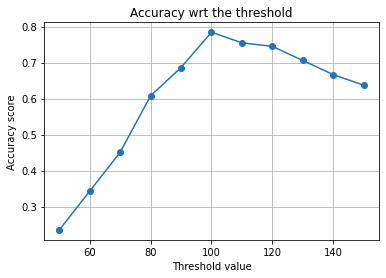

In [24]:
plt.plot(thresholds, accuracies, marker='o')
plt.title('Accuracy wrt the threshold')
plt.xlabel('Threshold value')
plt.ylabel('Accuracy score')
plt.grid(True)
plt.show()